In [1]:
!pip install torcheval

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.2/179.2 kB 4.8 MB/s eta 0:00:00


In [2]:
!pip install --upgrade wandb


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.3/20.3 MB 84.1 MB/s eta 0:00:00
  Attempting uninstall: wandb
    Found existing installation: wandb 0.18.3
    Uninstalling wandb-0.18.3:
      Successfully uninstalled wandb-0.18.3


## Import Libraries

In [3]:
import cv2 as cv
from skimage import segmentation
import cv2
import os
import gc
import math
import copy
import time
import random
import glob
from matplotlib import pyplot as plt

# For data manipulation
import numpy as np
import pandas as pd

# Pytorch Imports
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.optim import lr_scheduler
from torch.utils.data import Dataset, DataLoader
from torch.cuda import amp
import torchvision
from torch.cuda.amp import GradScaler, autocast
from torcheval.metrics.functional import binary_auroc
from torchmetrics.classification import BinaryAccuracy, BinaryPrecision, BinaryRecall, BinaryAUROC


# Utils
import joblib
from tqdm import tqdm
from collections import defaultdict

# Sklearn Imports
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold, StratifiedGroupKFold 
from sklearn.utils.class_weight import compute_class_weight


# For Image Models
import timm

import wandb

# Albumentations for augmentations
import albumentations as A
from albumentations.pytorch import ToTensorV2

# For colored terminal text
from colorama import Fore, Back, Style
b_ = Fore.BLUE
sr_ = Style.RESET_ALL

import warnings
warnings.filterwarnings("ignore")

# For descriptive error messages
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

/opt/conda/lib/python3.10/site-packages/albumentations/__init__.py:13: UserWarning: A new version of Albumentations is available: 2.0.0 (you have 1.4.17). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [4]:
try:
    from kaggle_secrets import UserSecretsClient
    user_secrets = UserSecretsClient()
    api_key = user_secrets.get_secret("WANDB")
    wandb.login(key=api_key)
    anonymous = None
except:
    anonymous = "must"
    print('To use your W&B account,\nGo to Add-ons -> Secrets and provide your W&B access token. Use the Label name as WANDB. \nGet your W&B access token from here: https://wandb.ai/authorize')

wandb: Currently logged in as: mahdiiut079 (mi79). Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [5]:
import wandb

wandb.login()  # Ensure you are logged in properly before running


True

## Configurations for EfficientNetB4

In [6]:
CONFIG = {
    "seed": 42,
    "epochs": 50,  # Increased epochs
    "img_size": 224,
    "model_name": "tf_efficientnet_b4_ns",
    "train_batch_size": 16,
    "valid_batch_size": 64,
    "learning_rate": 1e-4,  # Slightly higher learning rate
    "scheduler": 'ReduceLROnPlateau',
    "min_lr": 1e-6,
    # "T_max": 20,  # Adjusted for longer training duration
    "weight_decay": 1e-8,
    "fold": 0,
    "n_fold": 5,
    "n_accumulate": 1,
    "device": torch.device("cuda:0" if torch.cuda.is_available() else "cpu"),
    "patience": 10,  # Add patience for early stopping
}


## Configurations for Swin Transformer

In [7]:
# CONFIG = {
#     "seed": 42,
#     "epochs": 40,
#     "img_size": 224,
#     "model_name": "swin_tiny_patch4_window7_224",  # Smaller Swin Transformer
#     "train_batch_size": 16,  # Reduced batch size
#     "valid_batch_size": 16,  # Match training batch size
#     "learning_rate": 5e-5,
#     "scheduler": 'CosineAnnealingLR',
#     "min_lr": 1e-6,
#     "T_max": 10,
#     "weight_decay": 1e-4,
#     "fold": 0,
#     "n_fold": 5,
#     "n_accumulate": 2,  # Gradient accumulation
#     "device": torch.device("cuda:0" if torch.cuda.is_available() else "cpu"),
#     "patience": 5,
# }


In [8]:
# CONFIG = {
#     "seed": 42,
#     "epochs": 25,  # Reduced to prevent overfitting
#     "img_size": 224,
#     "model_name": "swin_tiny_patch4_window7_224",
#     "train_batch_size": 16,
#     "valid_batch_size": 16,
#     "learning_rate": 5e-5,  # Initial learning rate
#     "scheduler": 'ReduceLROnPlateau',  # Changed to ReduceLROnPlateau
#     "min_lr": 1e-6,  # Minimum LR for scheduler
#     "weight_decay": 1e-4,
#     "fold": 0,
#     "n_fold": 5,
#     "n_accumulate": 2,  # Gradient accumulation
#     "device": torch.device("cuda:0" if torch.cuda.is_available() else "cpu"),
#     "patience": 3,  # Patience for ReduceLROnPlateau
# }


## Reproducibility

In [9]:
def set_seed(seed=42):
    '''Sets the seed of the entire notebook so results are the same every time we run.
    This is for REPRODUCIBILITY.'''
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    # When running on the CuDNN backend, two further options must be set
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    # Set a fixed value for the hash seed
    os.environ['PYTHONHASHSEED'] = str(seed)
    
set_seed(CONFIG['seed'])

## Data loading

In [10]:
# # Define classes and the directory where files were extracted
# classes = ['others', 'nevus']
# image_dir_train = '/kaggle/input/skin-cancer-detecttion/train'

# # Initialize an empty list to store image file paths and their corresponding labels
# data = []

# # Loop through each class folder and each image within that folder
# for i, c in enumerate(classes):
#     class_dir = os.path.join(image_dir_train, c)
    
#     if os.path.exists(class_dir):
#         for filename in os.listdir(class_dir):
#             if filename.endswith(('.png', '.jpg', '.jpeg')):  # Filter image files
#                 image_path = os.path.join(class_dir, filename)
#                 data.append([image_path, c, i])  # Append image path and its label (class)

# # Create a pandas DataFrame from the data
# df_train = pd.DataFrame(data, columns=['image_path', 'label_name', 'label'])

In [11]:
# Data Loading
classes = ['others', 'nevus']
image_dir_train = '/kaggle/input/skin-cancer-detecttion/train'

def load_data(image_dir, classes):
    data = []
    for i, c in enumerate(classes):
        class_dir = os.path.join(image_dir, c)
        if os.path.exists(class_dir):
            for filename in os.listdir(class_dir):
                if filename.endswith(('.png', '.jpg', '.jpeg')):
                    data.append([os.path.join(class_dir, filename), c, i])
    return pd.DataFrame(data, columns=['image_path', 'label_name', 'label'])

df_train = load_data(image_dir_train, classes)

In [12]:
image_dir_valid = '/kaggle/input/skin-cancer-detecttion/val'

# Initialize an empty list to store image file paths and their corresponding labels
data = []

# Loop through each class folder and each image within that folder
for c in classes:
    class_dir = os.path.join(image_dir_valid, c)
    
    if os.path.exists(class_dir):
        for filename in os.listdir(class_dir):
            if filename.endswith(('.png', '.jpg', '.jpeg')):  # Filter image files
                image_path = os.path.join(class_dir, filename)
                data.append([image_path, c])  # Append image path and its label (class)

# Create a pandas DataFrame from the data
df_valid = pd.DataFrame(data, columns=['image_path', 'label'])

In [13]:
df_train

,image_path,label_name,label
0,/kaggle/input/skin-cancer-detecttion/train/oth...,others,0
1,/kaggle/input/skin-cancer-detecttion/train/oth...,others,0
2,/kaggle/input/skin-cancer-detecttion/train/oth...,others,0
3,/kaggle/input/skin-cancer-detecttion/train/oth...,others,0
4,/kaggle/input/skin-cancer-detecttion/train/oth...,others,0
...,...,...,...
15190,/kaggle/input/skin-cancer-detecttion/train/nev...,nevus,1
15191,/kaggle/input/skin-cancer-detecttion/train/nev...,nevus,1
15192,/kaggle/input/skin-cancer-detecttion/train/nev...,nevus,1
15193,/kaggle/input/skin-cancer-detecttion/train/nev...,nevus,1


In [14]:
df_valid

,image_path,label
0,/kaggle/input/skin-cancer-detecttion/val/other...,others
1,/kaggle/input/skin-cancer-detecttion/val/other...,others
2,/kaggle/input/skin-cancer-detecttion/val/other...,others
3,/kaggle/input/skin-cancer-detecttion/val/other...,others
4,/kaggle/input/skin-cancer-detecttion/val/other...,others
...,...,...
3791,/kaggle/input/skin-cancer-detecttion/val/nevus...,nevus
3792,/kaggle/input/skin-cancer-detecttion/val/nevus...,nevus
3793,/kaggle/input/skin-cancer-detecttion/val/nevus...,nevus
3794,/kaggle/input/skin-cancer-detecttion/val/nevus...,nevus


## KFolds

In [15]:
def create_folds(df, num_splits=5):
    df["kfold"] = -1
    skf = StratifiedKFold(n_splits=num_splits, shuffle=True, random_state=42)
    for fold, (train_idx, val_idx) in enumerate(skf.split(X=df, y=df.label)):
        df.loc[val_idx, "kfold"] = fold
    return df

# Add K-Folds to df_train
df_train = create_folds(df_train, num_splits=5)

## Sample data visualization

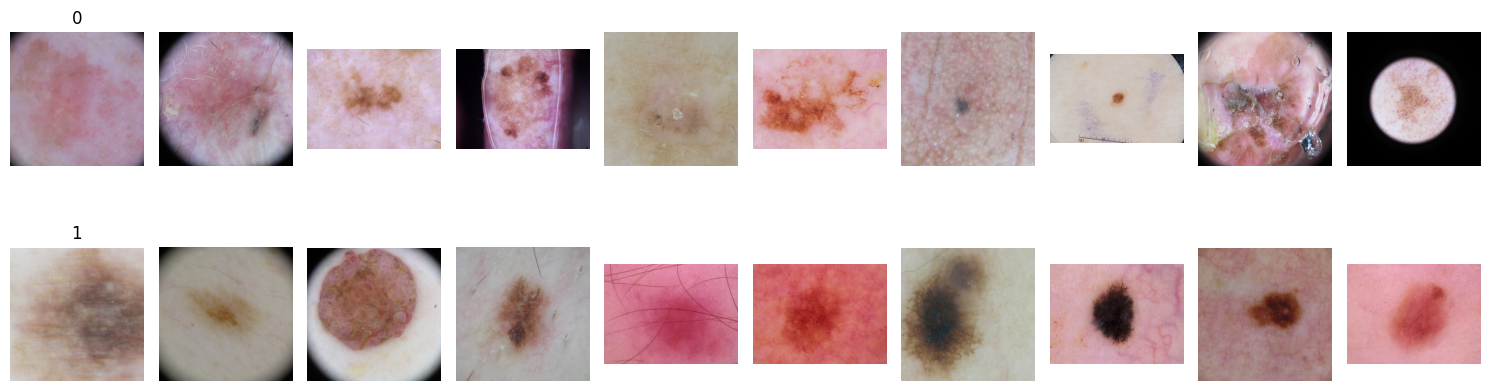

In [16]:
# Number of random images to select per class
num_images = 10

# Initialize a dictionary to store selected image paths by class
selected_images = {}

# Loop through each class and randomly sample 10 images
for c in df_train['label'].unique():
    class_images = df_train[df_train['label'] == c]  # Filter DataFrame by class
    sampled_images = class_images.sample(n=min(len(class_images), num_images))  # Randomly sample 10 images
    selected_images[c] = sampled_images['image_path'].tolist()

# Plot the randomly selected images
fig, axes = plt.subplots(len(selected_images), num_images, figsize=(15, 5))

for class_idx, c in enumerate(selected_images.keys()):
    for img_idx, img_path in enumerate(selected_images[c]):
        img = cv2.imread(img_path)
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB for matplotlib
        ax = axes[class_idx, img_idx]
        ax.imshow(img_rgb)
        ax.axis('off')  # Hide axis for cleaner display
        if img_idx == 0:
            ax.set_title(c)  # Set class label as title on the first image of each row

plt.tight_layout()
plt.show()

In [17]:
class Preprocessing:
    """
       Preprocessing class. This class's purpose is to preprocess the images in the dataset.
    """

    def _hair_removal(self, img, se_width=11, se_height=1, n_orientations=8):
        # Input validation for structuring element dimensions
        if se_width % 2 == 0:
            raise ValueError(f"Structuring element width ({se_width}) must be odd")
        if se_height % 2 == 0:
            raise ValueError(f"Structuring element height ({se_height}) must be odd")

        # Convert the original image to grayscale if it has more than 1 channel
        if len(img.shape) == 3:
            img_gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
        else:
            img_gray = img

        # Create tilted structuring elements
        base = np.zeros((se_width, se_width), dtype=np.uint8)
        for k in range(se_width // 2 - se_height // 2, se_width // 2 + se_height // 2 + 1):
            cv.line(base, (0, k), (se_width, k), 255)

        # Compute rotated structuring elements
        SEs = [base]
        angle_step = 180.0 / n_orientations
        for k in range(1, n_orientations):
            rotation_matrix = cv.getRotationMatrix2D((se_width / 2.0, se_width / 2.0), k * angle_step, 1.0)
            SE = cv.warpAffine(base, rotation_matrix, (se_width, se_width), flags=cv.INTER_NEAREST)
            SEs.append(SE)

        # Initialize sum of blackhat results
        sum_blackhats = np.zeros_like(img_gray, dtype=np.uint16)

        # Apply blackhat operation using each structuring element and accumulate results
        for SE in SEs:
            blackhat = cv.morphologyEx(img_gray, cv.MORPH_BLACKHAT, SE)
            sum_blackhats += blackhat

        # Normalize the sum of blackhats to the range 0-255 and convert to uint8
        cv.normalize(sum_blackhats, sum_blackhats, 0, 255, cv.NORM_MINMAX)
        sum_blackhats = sum_blackhats.astype(np.uint8)

        # Threshold the blackhat sum to create a binary mask for inpainting
        _, thresholded = cv.threshold(sum_blackhats, 0, 255, cv.THRESH_BINARY | cv.THRESH_TRIANGLE)

        # Refine the mask using morphological opening to remove small components
        thresholded = cv.morphologyEx(thresholded, cv.MORPH_OPEN, cv.getStructuringElement(cv.MORPH_ELLIPSE, (3, 3)))

        # Dilate the mask slightly to cover the hair regions more effectively
        thresholded = cv.dilate(thresholded, cv.getStructuringElement(cv.MORPH_ELLIPSE, (5, 5)))

        # Inpaint the original image using the created mask
        if len(img.shape) == 3:
            result = cv.inpaint(img, thresholded, 3, cv.INPAINT_NS)
        else:
            result = cv.inpaint(img_gray, thresholded, 3, cv.INPAINT_NS)

        return result
    
    def _color_constancy(self, img, power=5, gamma=1.4):
        """
        Apply color constancy to the input image using a power transformation and optional gamma correction.

        Parameters:
            img (numpy.ndarray): Input image.
            power (float): Power to use for the power transformation (default is 6).
            gamma (float, optional): Gamma value for gamma correction (default is 2.2).

        Returns:
            numpy.ndarray: Image with color constancy applied.
        """
        # Get the data type of the input image
        img_dtype = img.dtype

        # Apply gamma correction if gamma is provided
        if gamma is not None:
            img = img / 255.0  # Normalize to 0-1
            img = np.power(img, 1 / gamma)
            img = (img * 255).astype('float32')

        # Convert the image to float32 data type for further processing
        img = img.astype('float32')

        # Apply power transformation to the image
        img_power = np.power(img, power)

        # Calculate the mean of img_power along channels (0 and 1)
        rgb_vec = np.power(np.mean(img_power, axis=(0, 1)), 1 / power)

        # Calculate the L2 norm of rgb_vec
        rgb_norm = np.linalg.norm(rgb_vec)

        # Normalize rgb_vec to have unit length
        rgb_vec /= (rgb_norm + 1e-6)  # Added small value to avoid division by zero

        # Scale down rgb_vec to prevent overexposure (tuning parameter)
        scale_factor = 0.8  # Scale down the effect of rgb_vec
        rgb_vec = (1 / (rgb_vec * np.sqrt(3))) * scale_factor

        # Scale img using the adjusted color constancy vector
        img = img * rgb_vec
        img = np.clip(img, 0, 255)

        # Normalize the image to 0-255 if needed
        img = cv.normalize(img, None, 0, 255, cv.NORM_MINMAX)

        return img.astype(img_dtype)

    
    def _roi(self, img, threshold=50):
        # Image dimensions
        h, w = img.shape[:2]
        
        # Get the minimum dimension to avoid index errors
        min_dim = min(h, w)
        
        # Calculate mean values along the diagonal
        diagonal_values = np.mean(img[np.arange(min_dim), np.arange(min_dim), :], axis=1)

        # Find the first and last points where the threshold is crossed
        above_threshold = np.where(diagonal_values >= threshold)[0]
        if above_threshold.size == 0:
            # If no diagonal value exceeds the threshold, return the original image
            return img
        
        first_cross = above_threshold[0]
        last_cross = above_threshold[-1]
        
        # Set the coordinates to crop the image
        y1 = max(0, first_cross)
        y2 = min(h, last_cross + 1)
        x1 = max(0, first_cross)
        x2 = min(w, last_cross + 1)
        
        # Crop the image using the calculated coordinates
        img_new = img[y1:y2, x1:x2, :]
        
        # Ensure the cropped image is not empty
        if img_new.shape[0] == 0 or img_new.shape[1] == 0:
            return img

        return img_new
    

    def _add_padd_to_image(self, img, padding_size):
        # Get the dimensions of the original image
        height_original, width_original = img.shape

        # Create a new larger image with black padding
        new_height = height_original + 2 * padding_size
        new_width = width_original + 2 * padding_size
        padding_image = np.zeros((new_height, new_width), dtype=np.uint8)

        # Calculate the position to place the original image in the center of the new image
        x_offset = padding_size
        y_offset = padding_size

        # Copy the original image into the center of the new image
        padding_image[y_offset:y_offset + height_original, x_offset:x_offset + width_original] = img

        return padding_image, height_original, width_original

    def _back_original_shape(self, eroded_mask, width_original, height_original, padding_size):
        # Back to the original shape
        crop_x_start = padding_size
        crop_x_end = padding_size + width_original
        crop_y_start = padding_size
        crop_y_end = padding_size + height_original

        # Crop the padded image to the original size
        cropped_mask = 255 - eroded_mask[crop_y_start:crop_y_end, crop_x_start:crop_x_end]

        return cropped_mask

    def _plot_results(self, img, image_file, hair_removed_image, roi_image, cn_hair_removed_image, segmented_image, cropped_mask_3_channels, final_image):
        # Create a figure with a larger size
        plt.figure(figsize=(14, 4))

        # Display the original image
        plt.subplot(1, 6, 1)
        plt.imshow(cv.cvtColor(img, cv.COLOR_BGR2RGB))
        plt.title(f'Original: {image_file}', fontsize=5)
        plt.axis('off')

        # Display the hair-removed image
        plt.subplot(1, 6, 2)
        plt.imshow(cv.cvtColor(hair_removed_image, cv.COLOR_BGR2RGB))
        plt.title('Step 1: Hair Removal', fontsize=5)
        plt.axis('off')

        # Display the color-normalized image
        plt.subplot(1, 6, 3)
        plt.imshow(cv.cvtColor(cn_hair_removed_image, cv.COLOR_BGR2RGB))
        plt.title('Step 2: Color Normalization', fontsize=5)
        plt.axis('off')

        # Display the ROI image
        plt.subplot(1, 6, 4)
        plt.imshow(cv.cvtColor(roi_image, cv.COLOR_BGR2RGB))
        plt.title('Step 3: ROI Image', fontsize=5)
        plt.axis('off')

        # Display the eroded mask
        plt.subplot(1, 6, 5)
        plt.imshow(cv.cvtColor(cropped_mask_3_channels, cv.COLOR_BGR2RGB))
        plt.title('Step 4: Padding + Binary Mask', fontsize=5)
        plt.axis('off')

        # Display the final image
        plt.subplot(1, 6, 6)
        plt.imshow(cv.cvtColor(final_image, cv.COLOR_BGR2RGB))
        plt.title('Final Image', fontsize=5)
        plt.axis('off')

        # Adjust the spacing between subplots
        plt.tight_layout()
        plt.savefig("preprocessing.png")
        plt.show()

    def preprocess_image(self, img, image_file, plot_results):
        # Call the function to remove the hairs from the image
        hair_removed_image = self._hair_removal(img)
        # Call the function to normalize the colors
        cn_hair_removed_image = self._color_constancy(hair_removed_image)
        # Call the function to crop the images
        roi_image = self._roi(cn_hair_removed_image)

        # Apply Gaussian blur
        kernel_size = (5, 5)
        sigma_x = 0
        img_blurred = cv.GaussianBlur(roi_image, kernel_size, sigma_x)
        img_gray = cv.cvtColor(img_blurred, cv.COLOR_BGR2GRAY)

        # Define padding size
        padding_size = 50
        padding_image, height_original, width_original = self._add_padd_to_image(img_gray, padding_size)

        # Region growing algorithm
        seed = (0, 0)
        segmented_image = segmentation.flood_fill(padding_image, seed_point=seed, new_value=0, tolerance=30)

        # Apply the thresholding to create the binary mask
        mask = np.where(segmented_image == 0, 255, 0).astype(np.uint8)

        # Define the kernel for erosion
        kernel_size = 11
        kernel = np.ones((kernel_size, kernel_size), np.uint8)

        # We remove small elements
        mask = cv.dilate(cv.erode(mask, kernel, iterations=5), kernel, iterations=5)

        # We dilate the mask
        eroded_mask = cv.dilate(mask, kernel, iterations=5)

        # Back to the original shape
        cropped_mask = self._back_original_shape(eroded_mask, width_original, height_original, padding_size)

        # Final output
        cropped_mask_3_channels = cv.cvtColor(cropped_mask, cv.COLOR_GRAY2BGR)
        final_image = 255 - (cropped_mask_3_channels * roi_image)

        # Plot results
        if plot_results:
            self._plot_results(img, image_file, hair_removed_image, roi_image, cn_hair_removed_image, segmented_image, cropped_mask_3_channels, final_image)

        return final_image

    def preprocess_image_ROI(self, img):
        roi_image = self._roi(img)

        # Apply Gaussian blur
        kernel_size = (5, 5)
        sigma_x = 0
        img_blurred = cv.GaussianBlur(roi_image, kernel_size, sigma_x)
        img_gray = cv.cvtColor(img_blurred, cv.COLOR_BGR2GRAY)

        # Define padding size
        padding_size = 50
        padding_image, height_original, width_original = self._add_padd_to_image(img_gray, padding_size)

        # Region growing algorithm
        seed = (0, 0)
        segmented_image = segmentation.flood_fill(padding_image, seed_point=seed, new_value=0, tolerance=30)

        # Apply the thresholding to create the binary mask
        mask = np.where(segmented_image == 0, 255, 0).astype(np.uint8)

        # Define the kernel for erosion
        kernel_size = 11
        kernel = np.ones((kernel_size, kernel_size), np.uint8)

        # We remove small elements
        mask = cv.dilate(cv.erode(mask, kernel, iterations=5), kernel, iterations=5)

        # We dilate the mask
        eroded_mask = cv.dilate(mask, kernel, iterations=5)

        # Back to the original shape
        cropped_mask = self._back_original_shape(eroded_mask, width_original, height_original, padding_size)

        # Final output
        cropped_mask_3_channels = cv.cvtColor(cropped_mask, cv.COLOR_GRAY2BGR)
        final_image = 255 - (cropped_mask_3_channels * roi_image)

        return final_image

## Preprocessing

In [18]:
preprocessing = Preprocessing()

In [19]:
# Initialize variables for mean and standard deviation calculation
channel_sum, channel_squared_sum = np.zeros(3), np.zeros(3)
num_images = len(df_train)  # Total number of images

# Iterate through df_train
for idx, row in df_train.iterrows():
    img_path = row['image_path']
    # Read the image
    img = cv2.imread(img_path)

    # Preprocess the image using your preprocessing function
    prepoc_img = preprocessing.preprocess_image(img, img_path, plot_results=False)

    # Convert the preprocessed image to a PyTorch tensor and normalize to [0, 1]
    prepoc_img_tensor = torch.tensor(prepoc_img.transpose(2, 0, 1), dtype=torch.float32) / 255.0  # HWC to CHW

    # Update channel sums
    channel_sum += prepoc_img_tensor.mean(dim=[1, 2]).numpy()
    channel_squared_sum += (prepoc_img_tensor**2).mean(dim=[1, 2]).numpy()

# Calculate the mean and standard deviation
mean = channel_sum / num_images
stddev = np.sqrt(channel_squared_sum / num_images - mean**2)

# Display the results
print("Training Dataset Normalization:")
print("Mean              :", mean)
print("Standard Deviation:", stddev)


Training Dataset Normalization:
Mean              : [0.71206467 0.72267604 0.74982272]
Standard Deviation: [0.22178884 0.20703684 0.1648961 ]


## Creating Dataset Class

In [20]:
# class ISICDataset_for_Train(Dataset):
#     def __init__(self, df, transforms=None, preprocessor=None):
#         self.df_positive = df[df["label"] == 1].reset_index()
#         self.df_negative = df[df["label"] == 0].reset_index()
#         self.file_names_positive = self.df_positive['image_path'].values
#         self.file_names_negative = self.df_negative['image_path'].values
#         self.labels_positive = self.df_positive['label'].values
#         self.labels_negative = self.df_negative['label'].values
#         self.transforms = transforms
#         self.preprocessor = preprocessor  # Pass the Preprocessing object

#     def __len__(self):
#         return len(self.df_positive) * 2

#     def __getitem__(self, index):
#         # Select positive or negative samples with equal probability
#         if random.random() >= 0.5:
#             df = self.df_positive
#             file_names = self.file_names_positive
#             labels = self.labels_positive
#         else:
#             df = self.df_negative
#             file_names = self.file_names_negative
#             labels = self.labels_negative
#         index = index % df.shape[0]

#         img_path = file_names[index]
#         img = cv2.imread(img_path)
#         img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
#         label = int(labels[index])

#         # Apply the preprocessing pipeline
#         if self.preprocessor:
#             img = self.preprocessor.preprocess_image(img, image_file=img_path, plot_results=False)

#         # Apply additional transformations (if provided)
#         if self.transforms:
#             img = self.transforms(image=img)["image"]

#         # Convert image and label to PyTorch tensors
#         img_tensor = torch.tensor(img, dtype=torch.float32) if isinstance(img, np.ndarray) else img
#         label_tensor = torch.tensor(label, dtype=torch.float32)

#         return {
#             'image': img,
#             'label': torch.tensor(label, dtype=torch.floar
#         }



# class ISICDataset(Dataset):
#     def __init__(self, df, transforms=None, preprocessor=None):
#         self.df = df
#         self.file_names = df['image_path'].values
#         self.labels = df['label'].values
#         self.transforms = transforms
#         self.preprocessor = preprocessor  # Pass the Preprocessing object

#     def __len__(self):
#         return len(self.df)

#     def __getitem__(self, index):
#         img_path = self.file_names[index]
#         img = cv2.imread(img_path)
#         img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
#         label = self.labels[index]

#         # Apply the preprocessing pipeline
#         if self.preprocessor:
#             img = self.preprocessor.preprocess_image(img, image_file=img_path, plot_results=False)

#         # Apply additional transformations (if provided)
#         if self.transforms:
#             img = self.transforms(image=img)["image"]   

#         return {
#             'image': torch.tensor(img, dtype=torch.float32),  # Ensure image is a tensor
#             'label': torch.tensor(label, dtype=torch.float32)  # Ensure label is a tensor
#         }


In [21]:
# class ISICDataset_for_Train(Dataset):
#     def __init__(self, df, transforms=None, preprocessor=None):
#         self.df_positive = df[df["label"] == 1].reset_index(drop=True)
#         self.df_negative = df[df["label"] == 0].reset_index(drop=True)
#         self.file_names_positive = self.df_positive['image_path'].values
#         self.file_names_negative = self.df_negative['image_path'].values
#         self.labels_positive = self.df_positive['label'].values
#         self.labels_negative = self.df_negative['label'].values
#         self.transforms = transforms
#         self.preprocessor = preprocessor  # Pass the Preprocessing object

#     def __len__(self):
#         return len(self.df_positive) * 2

#     def __getitem__(self, index):
#         # Select positive or negative samples with equal probability
#         if random.random() >= 0.5:
#             file_names = self.file_names_positive
#             labels = self.labels_positive
#         else:
#             file_names = self.file_names_negative
#             labels = self.labels_negative
        
#         index = index % len(file_names)

#         # Load the image
#         img_path = file_names[index]
#         try:
#             img = cv2.imread(img_path)
#             if img is None:
#                 raise ValueError(f"Image not found or invalid at path: {img_path}")
#             img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
#         except Exception as e:
#             raise RuntimeError(f"Error loading image {img_path}: {e}")
        
#         label = int(labels[index])

#         # Apply the preprocessing pipeline
#         if self.preprocessor:
#             img = self.preprocessor.preprocess_image(img, image_file=img_path, plot_results=False)

#         # Apply additional transformations (if provided)
#         if self.transforms:
#             img = self.transforms(image=img)["image"]  # Albumentations expects 'image'

#         # Ensure the image has the correct shape for PyTorch (C, H, W)
#         if isinstance(img, np.ndarray):
#             img = np.transpose(img, (2, 0, 1))  # HWC to CHW
#         img_tensor = torch.tensor(img, dtype=torch.float32)
#         #label_tensor = torch.tensor(label, dtype=torch.float32).unsqueeze(0)
#         label_tensor = torch.tensor(label, dtype=torch.float32).view(1)  # Ensure shape [1]
#         # Add .unsqueeze(0)
#         #print(f"Image Tensor Shape: {img_tensor.shape}")
#         #print(f"Label Tensor Shape: {label_tensor.shape}")


#         return {
#             'image': img_tensor,
#             'label': label_tensor
#         }


# class ISICDataset(Dataset):
#     def __init__(self, df, transforms=None, preprocessor=None):
#         self.df = df
#         self.file_names = df['image_path'].values
#         self.labels = df['label'].values
#         self.transforms = transforms
#         self.preprocessor = preprocessor  # Pass the Preprocessing object

#     def __len__(self):
#         return len(self.df)

#     def __getitem__(self, index):
#         # Load the image
#         img_path = self.file_names[index]
#         try:
#             img = cv2.imread(img_path)
#             if img is None:
#                 raise ValueError(f"Image not found or invalid at path: {img_path}")
#             img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
#         except Exception as e:
#             raise RuntimeError(f"Error loading image {img_path}: {e}")
        
#         label = int(self.labels[index])

#         # Apply the preprocessing pipeline
#         if self.preprocessor:
#             img = self.preprocessor.preprocess_image(img, image_file=img_path, plot_results=False)

#         # Apply additional transformations (if provided)
#         if self.transforms:
#             img = self.transforms(image=img)["image"]  # Albumentations expects 'image'

#         # Ensure the image has the correct shape for PyTorch (C, H, W)
#         if isinstance(img, np.ndarray):
#             img = np.transpose(img, (2, 0, 1))  # HWC to CHW
#         img_tensor = torch.tensor(img, dtype=torch.float32)
#         #label_tensor = torch.tensor(label, dtype=torch.float32).unsqueeze(0)  # Add .unsqueeze(0)
#         label_tensor = torch.tensor(label, dtype=torch.float32).view(1)  # Ensure shape [1]
#         #print(f"Image Tensor Shape: {img_tensor.shape}")
#         #print(f"Label Tensor Shape: {label_tensor.shape}")



#         return {
#             'image': img_tensor,
#             'label': label_tensor
#         }


In [22]:
# class ISICDataset_for_Train(Dataset):
#     def __init__(self, df, transforms=None, preprocessor=None):
#         self.df_positive = df[df["label"] == 1].reset_index(drop=True)
#         self.df_negative = df[df["label"] == 0].reset_index(drop=True)
#         self.file_names_positive = self.df_positive['image_path'].values
#         self.file_names_negative = self.df_negative['image_path'].values
#         self.labels_positive = self.df_positive['label'].values
#         self.labels_negative = self.df_negative['label'].values
#         self.transforms = transforms
#         self.preprocessor = preprocessor

#     def __len__(self):
#         return len(self.df_positive) * 2

#     def __getitem__(self, index):
#         if random.random() >= 0.5:
#             file_names = self.file_names_positive
#             labels = self.labels_positive
#         else:
#             file_names = self.file_names_negative
#             labels = self.labels_negative

#         index = index % len(file_names)
#         img_path = file_names[index]
#         try:
#             img = cv2.imread(img_path)
#             if img is None:
#                 raise ValueError(f"Image not found or invalid at path: {img_path}")
#             img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
#         except Exception as e:
#             raise RuntimeError(f"Error loading image {img_path}: {e}")
        
#         label = int(labels[index])

#         # Apply preprocessing
#         if self.preprocessor:
#             img = self.preprocessor.preprocess_image(img, image_file=img_path, plot_results=False)

#         # Apply transformations
#         if self.transforms:
#             img = self.transforms(image=img)["image"]

#         # Convert to tensors
#         if isinstance(img, np.ndarray):
#             img = np.transpose(img, (2, 0, 1))  # HWC to CHW
#         img_tensor = torch.tensor(img, dtype=torch.float32)
#         label_tensor = torch.tensor(label, dtype=torch.float32)  # [1]

#         return {
#             'image': img_tensor,
#             'label': label_tensor
#         }


In [23]:
class ISICDataset(Dataset):
    def __init__(self, df, transforms=None, preprocessor=None):
        self.df = df
        self.file_names = df['image_path'].values
        self.labels = df['label'].values
        self.transforms = transforms
        self.preprocessor = preprocessor

    def __len__(self):
        return len(self.df)

    def __getitem__(self, index):
        img_path = self.file_names[index]
        try:
            img = cv2.imread(img_path)
            if img is None:
                raise ValueError(f"Image not found or invalid at path: {img_path}")
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        except Exception as e:
            raise RuntimeError(f"Error loading image {img_path}: {e}")
        
        label = int(self.labels[index])

        # Apply preprocessing
        if self.preprocessor:
            img = self.preprocessor.preprocess_image(img, image_file=img_path, plot_results=False)

        # Apply transformations
        if self.transforms:
            img = self.transforms(image=img)["image"]

        # Convert to tensors
        if isinstance(img, np.ndarray):
            img = np.transpose(img, (2, 0, 1))  # HWC to CHW
        img_tensor = torch.tensor(img, dtype=torch.float32)
        label_tensor = torch.tensor(label, dtype=torch.float32)  # [1]


        return {
            'image': img_tensor,
            'label': label_tensor
        }


## Creating the Pooling Layers

In [24]:
# class GeM(nn.Module):
#     def __init__(self, p=3, eps=1e-6):
#         super(GeM, self).__init__()
#         self.p = nn.Parameter(torch.ones(1)*p)
#         self.eps = eps

#     def forward(self, x):
#         return self.gem(x, p=self.p, eps=self.eps)
        
#     def gem(self, x, p=3, eps=1e-6):
#         return F.avg_pool2d(x.clamp(min=eps).pow(p), (x.size(-2), x.size(-1))).pow(1./p)
        
#     def __repr__(self):
#         return self.__class__.__name__ + \
#                 '(' + 'p=' + '{:.4f}'.format(self.p.data.tolist()[0]) + \
#                 ', ' + 'eps=' + str(self.eps) + ')'

In [25]:
class AveragePooling(nn.Module):
    def __init__(self, eps=1e-6):
        """
        A simple average pooling layer replacing GeM.
        
        Args:
            eps (float): Small constant to avoid numerical instability. Default is 1e-6.
        """
        super(AveragePooling, self).__init__()
        self.eps = eps

    def forward(self, x):
        """
        Forward pass of average pooling.

        Args:
            x (Tensor): Input tensor.

        Returns:
            Tensor: Output tensor after global average pooling.
        """
        # Global average pooling over the spatial dimensions
        return F.avg_pool2d(x.clamp(min=self.eps), (x.size(-2), x.size(-1)))

    def __repr__(self):
        return f"{self.__class__.__name__}(eps={self.eps})"


## Model

In [26]:
# class ISICModel(nn.Module):
#     def __init__(self, model_name, num_classes=1, pretrained=True, checkpoint_path=None):
#         super(ISICModel, self).__init__()
#         self.model = timm.create_model(model_name, pretrained=pretrained, checkpoint_path=checkpoint_path)

#         in_features = self.model.classifier.in_features
#         self.model.classifier = nn.Identity()
#         self.model.global_pool = nn.Identity()
#         self.pooling = GeM()
#         self.linear = nn.Linear(in_features, num_classes)
#         self.sigmoid = nn.Sigmoid()

#     def forward(self, images):
#         features = self.model(images)
#         pooled_features = self.pooling(features).flatten(1)
#         output = self.sigmoid(self.linear(pooled_features))
#         return output

    
# model = ISICModel(CONFIG['model_name'])
# model.to(CONFIG['device']);

In [27]:
# class ISICModel(nn.Module):
#     def __init__(self, model_name, num_classes=1, pretrained=True, checkpoint_path=None):
#         super(ISICModel, self).__init__()
#         # Create the base model using timm
#         self.model = timm.create_model(model_name, pretrained=pretrained, checkpoint_path=checkpoint_path)
        
#         # Get the number of features in the backbone's classifier
#         in_features = self.model.classifier.in_features
        
#         # Replace the classifier with an identity layer to use custom pooling and classification
#         self.model.classifier = nn.Identity()
#         self.model.global_pool = nn.Identity()
        
#         # Add custom layers
#         self.pooling = GeM()  # Generalized Mean Pooling
#         self.dropout = nn.Dropout(0.3)  # Dropout for regularization
#         self.linear = nn.Linear(in_features, 1)  # Single output for binary classification
    

#     def forward(self, images):
#         # Extract features from the backbone
#         features = self.model(images)
        
#         # Apply pooling and flatten the features
#         pooled_features = self.pooling(features).flatten(1)
        
#         # Apply dropout for regularization
#         dropped_features = self.dropout(pooled_features)
        
#         # Apply linear layer and sigmoid activation for binary classification
#         output = self.linear(dropped_features)
#         return output


## Model_Efficientnet

In [28]:
class ISICModel(nn.Module):
    def __init__(self, model_name, num_classes=1, pretrained=True, checkpoint_path=None):
        """
        A binary classification model for skin lesion images.
        
        Args:
            model_name (str): Name of the model backbone from timm.
            num_classes (int): Number of output classes. Default is 1 for binary classification.
            pretrained (bool): Whether to use pretrained weights. Default is True.
            checkpoint_path (str): Path to a specific checkpoint. Default is None.
        """
        super(ISICModel, self).__init__()
        # Create the base model using timm
        self.model = timm.create_model(model_name, pretrained=pretrained, checkpoint_path=checkpoint_path)
        
        # Get the number of features in the backbone's classifier
        in_features = self.model.classifier.in_features
        
        # Replace the classifier with an identity layer to use custom pooling and classification
        self.model.classifier = nn.Identity()
        self.model.global_pool = nn.Identity()
        
        # Add custom layers
        self.pooling = nn.AdaptiveAvgPool2d((1, 1))  # Global Average Pooling
        self.dropout = nn.Dropout(0.3)  # Dropout for regularization
        self.batch_norm = nn.BatchNorm1d(in_features)
        self.linear = nn.Linear(in_features, num_classes)  # Single output for binary classification
    

    def forward(self, images):
        # Extract features from the backbone
        features = self.model(images)
        
        # Apply pooling and flatten the features
        pooled_features = self.pooling(features).flatten(1)

        # Apply batch normalization
        normalized_features = self.batch_norm(pooled_features)
        
        # Apply dropout for regularization
        dropped_features = self.dropout(normalized_features)
        
        # Apply linear layer and sigmoid activation for binary classification
        output = self.linear(dropped_features)
        return output


## Swin Transformer

In [29]:
# class ISICModel(nn.Module):
#     def __init__(self, model_name, num_classes=1, pretrained=True, checkpoint_path=None):
#         """
#         A binary classification model for skin lesion images using Swin Transformer.
        
#         Args:
#             model_name (str): Name of the model backbone from timm.
#             num_classes (int): Number of output classes. Default is 1 for binary classification.
#             pretrained (bool): Whether to use pretrained weights. Default is True.
#             checkpoint_path (str): Path to a specific checkpoint. Default is None.
#         """
#         super(ISICModel, self).__init__()
#         # Create the base model using timm
#         self.model = timm.create_model(model_name, pretrained=pretrained, checkpoint_path=checkpoint_path)
        
#         # Get the number of features in the backbone's output
#         in_features = self.model.num_features  # Swin's feature size (e.g., 768)
        
#         # Replace the classifier with an identity layer
#         self.model.head = nn.Identity()
        
#         # Add custom layers
#         self.pooling = nn.AdaptiveAvgPool2d((1, 1))  # Global average pooling
#         self.dropout = nn.Dropout(0.5)  # Dropout for regularization
#         self.batch_norm = nn.BatchNorm1d(in_features)
#         self.linear = nn.Linear(in_features, num_classes)  # Output layer
    

#     def forward(self, images):
#         # Print the input shape
#         # print(f"Input Shape: {images.shape}")  # Input to the model
    
#         # Extract features from the backbone
#         features = self.model(images)  # Shape: [batch_size, 7, 7, 768]
#         # print(f"Backbone Output Shape: {features.shape}")  # After passing through the backbone
        
#         # Correctly permute dimensions for pooling
#         features = features.permute(0, 3, 1, 2)  # Change to [batch_size, num_channels, height, width]
        
#         # Apply pooling to reduce height and width
#         pooled_features = self.pooling(features).squeeze(-1).squeeze(-1)  # Shape: [batch_size, num_channels]
#         # print(f"Pooled Features Shape: {pooled_features.shape}")  # After pooling

         
#         # Apply batch normalization
#         normalized_features = self.batch_norm(pooled_features)
        
#         # Apply dropout for regularization
#         dropped_features = self.dropout(normalized_features)
#         # print(f"Dropped Features Shape: {dropped_features.shape}")  # After dropout
        
#         # Apply linear layer for binary classification
#         output = self.linear(dropped_features)  # Shape: [batch_size, num_classes]
#         # print(f"Output Shape: {output.shape}")  # Final output
        
#         return output



## Loss Function

In [30]:
criterion = nn.BCEWithLogitsLoss()

## Train one epoch

In [31]:
# def train_one_epoch(model, optimizer, scheduler, dataloader, device, epoch):
#     model.train()
    
#     dataset_size = 0
#     running_loss = 0.0
#     running_auroc = 0.0
    
#     bar = tqdm(enumerate(dataloader), total=len(dataloader))
#     for step, data in bar:
#         images = data['image'].to(device, dtype=torch.float)
#         targets = data['label'].to(device, dtype=torch.float).unsqueeze(1)  # Ensure [batch_size, 1]
#         # Explicitly match targets shape with outputs
#         # targets = targets.view(-1, 1)  # Ensure shape is [batch_size, 1]
#         #targets = data['label'].to(device, dtype=torch.float).view(-1, 1) 
#         batch_size = images.size(0)
        
#         outputs = model(images)
        
#         # Debugging Shapes
#         #print(f"Step {step} - Outputs shape: {outputs.shape}")
#         #print(f"Step {step} - Targets shape: {targets.shape}")

#         # Check for shape mismatch
#         #if outputs.shape != targets.shape:
#             #raise ValueError(f"Shape mismatch: Outputs shape {outputs.shape}, Targets shape {targets.shape}")

        
#         loss = criterion(outputs, targets)
#         loss = loss / CONFIG['n_accumulate']
            
#         loss.backward()
    
#         if (step + 1) % CONFIG['n_accumulate'] == 0:
#             optimizer.step()
#             optimizer.zero_grad()

#             if scheduler is not None:
#                 scheduler.step()
                
#         auroc = binary_auroc(input=outputs.squeeze(-1), target=targets.squeeze(-1)).item()
        
#         running_loss += (loss.item() * batch_size)
#         running_auroc += (auroc * batch_size)
#         dataset_size += batch_size
        
#         epoch_loss = running_loss / dataset_size
#         epoch_auroc = running_auroc / dataset_size
        
#         bar.set_postfix(Epoch=epoch, Train_Loss=epoch_loss, Train_Auroc=epoch_auroc,
#                         LR=optimizer.param_groups[0]['lr'])
#     gc.collect()
    
#     return epoch_loss, epoch_auroc


In [32]:
# from torchmetrics.classification import BinaryAUROC

# def train_one_epoch(model, optimizer, scheduler, dataloader, device, epoch):
#     model.train()
#     dataset_size = 0
#     running_loss = 0.0
#     auroc_metric = BinaryAUROC().to(device)  # Initialize AUROC metric

#     bar = tqdm(enumerate(dataloader), total=len(dataloader))
#     for step, data in bar:
#         images = data['image'].to(device, dtype=torch.float)
#         targets = data['label'].to(device, dtype=torch.float).view(-1, 1)  # Reshape to [batch_size, 1]

#         # Forward pass
#         outputs = model(images)

#         # Compute loss with built-in weighting
#         loss = criterion(outputs, targets)

#         # Backward pass
#         loss.backward()
#         optimizer.step()
#         optimizer.zero_grad()

#         if scheduler is not None:
#             scheduler.step()

#         # Update metrics
#         running_loss += loss.item() * targets.size(0)
#         auroc_metric.update(outputs.sigmoid(), targets)

#         # Calculate metrics
#         dataset_size += targets.size(0)
#         epoch_loss = running_loss / dataset_size
#         epoch_auroc = auroc_metric.compute().item()

#         # Update progress bar
#         bar.set_postfix(Epoch=epoch, Train_Loss=epoch_loss, Train_AUROC=epoch_auroc)

#     # Reset AUROC for the next epoch
#     auroc_metric.reset()
#     gc.collect()
#     return epoch_loss, epoch_auroc


In [33]:
# def train_one_epoch(model, optimizer, scheduler, dataloader, device, epoch):
#     model.train()
    
#     running_loss = 0.0
#     dataset_size = 0
    
#     # Metrics
#     accuracy = BinaryAccuracy().to(device)
#     precision = BinaryPrecision().to(device)
#     recall = BinaryRecall().to(device)
#     auroc = BinaryAUROC().to(device)
    
#     bar = tqdm(enumerate(dataloader), total=len(dataloader))
#     for step, data in bar:
#         images = data['image'].to(device, dtype=torch.float)
#         targets = data['label'].to(device, dtype=torch.float).unsqueeze(1)  # Shape [batch_size, 1]
        
#         # Debug shapes after data loading
#         #print(f"Step {step} - Images shape: {images.shape}, Targets shape: {targets.shape}")
        
#         # Forward pass
#         outputs = model(images)
#         #print(f"Step {step} - Outputs shape: {outputs.shape}")
        
#         # Compute loss
#         loss = criterion(outputs, targets)
        
#         # Backward pass
#         loss.backward()
#         optimizer.step()
#         optimizer.zero_grad()
        
#         # Update running loss
#         batch_size = images.size(0)
#         running_loss += loss.item() * batch_size
#         dataset_size += batch_size
        
#         # Update metrics
#         accuracy.update(outputs, targets.int())
#         precision.update(outputs, targets.int())
#         recall.update(outputs, targets.int())
#         auroc.update(outputs, targets.int())
        
#         # Epoch metrics
#         epoch_loss = running_loss / dataset_size
#         epoch_accuracy = accuracy.compute().item()
#         epoch_precision = precision.compute().item()
#         epoch_recall = recall.compute().item()
#         epoch_auroc = auroc.compute().item()
        
#         # Debug current batch metrics
#         print(f"Step {step} - Batch Accuracy: {epoch_accuracy}, Precision: {epoch_precision}, Recall: {epoch_recall}, AUROC: {epoch_auroc}")
        
#         # Update progress bar
#         bar.set_postfix(Epoch=epoch, Train_Loss=epoch_loss, Accuracy=epoch_accuracy,
#                         Precision=epoch_precision, Recall=epoch_recall, AUROC=epoch_auroc,
#                         LR=optimizer.param_groups[0]['lr'])
    
#     # Reset metrics
#     accuracy.reset()
#     precision.reset()
#     recall.reset()
#     auroc.reset()
    
#     return epoch_loss, epoch_accuracy, epoch_precision, epoch_recall, epoch_auroc


## Train_one_Epoch for Swin

In [34]:
scaler = GradScaler()

def train_one_epoch(model, optimizer, scheduler, dataloader, device, epoch):
    model.train()
    
    running_loss = 0.0
    dataset_size = 0
    
    # Metrics
    accuracy = BinaryAccuracy().to(device)
    precision = BinaryPrecision().to(device)
    recall = BinaryRecall().to(device)
    auroc = BinaryAUROC().to(device)
    
    accumulation_steps = CONFIG.get("n_accumulate", 1)
    
    bar = tqdm(enumerate(dataloader), total=len(dataloader))
    for step, data in bar:
        images = data['image'].to(device, dtype=torch.float)
        targets = data['label'].to(device, dtype=torch.float).unsqueeze(1)  # Shape [batch_size, 1]
        
        # Mixed precision training
        with autocast():
            outputs = model(images)
            loss = criterion(outputs, targets)
        
        # Backward pass with gradient accumulation
        scaler.scale(loss).backward()
        
        if (step + 1) % accumulation_steps == 0 or (step + 1) == len(dataloader):
            scaler.step(optimizer)
            scaler.update()
            optimizer.zero_grad()
        
        # Update running loss
        batch_size = images.size(0)
        running_loss += loss.item() * batch_size
        dataset_size += batch_size
        
        # Update metrics
        accuracy.update(outputs, targets.int())
        precision.update(outputs, targets.int())
        recall.update(outputs, targets.int())
        auroc.update(outputs, targets.int())
        
        # Epoch metrics
        epoch_loss = running_loss / dataset_size
        epoch_accuracy = accuracy.compute().item()
        epoch_precision = precision.compute().item()
        epoch_recall = recall.compute().item()
        epoch_auroc = auroc.compute().item()
        
        # Update progress bar
        bar.set_postfix(Epoch=epoch, Train_Loss=epoch_loss, Accuracy=epoch_accuracy,
                        Precision=epoch_precision, Recall=epoch_recall, AUROC=epoch_auroc,
                        LR=optimizer.param_groups[0]['lr'])
        
        # (Optional) Update scheduler per batch
        if CONFIG["scheduler"] == "CosineAnnealingWarmRestarts":
            scheduler.step(epoch + step / len(dataloader))
    
    # Reset metrics
    accuracy.reset()
    precision.reset()
    recall.reset()
    auroc.reset()
    
    # Update scheduler per epoch (if not batch-level)
    if CONFIG["scheduler"] != "CosineAnnealingWarmRestarts":
        scheduler.step(epoch_loss)
    
    return epoch_loss, epoch_accuracy, epoch_precision, epoch_recall, epoch_auroc

## Valid one epoch

In [35]:
# @torch.inference_mode()
# def valid_one_epoch(model, dataloader, device, epoch):
#     model.eval()
    
#     dataset_size = 0
#     running_loss = 0.0
#     running_auroc = 0.0
    
#     bar = tqdm(enumerate(dataloader), total=len(dataloader))
#     for step, data in bar:        
#         images = data['image'].to(device, dtype=torch.float)
#         targets = data['label'].to(device, dtype=torch.float).unsqueeze(1)
        
#         batch_size = images.size(0)

#         outputs = model(images)
#         # Debugging Shapes
#         #print(f"Step {step} - Outputs shape: {outputs.shape}")
#         #print(f"Step {step} - Targets shape: {targets.shape}")

#         # Ensure the shapes match
#         #if outputs.shape != targets.shape:
#             #raise RuntimeError(f"Shape mismatch: Outputs shape {outputs.shape}, Targets shape {targets.shape}")
        
#         loss = criterion(outputs, targets)

#         auroc = binary_auroc(input=outputs.squeeze(-1), target=targets.squeeze(-1)).item()
#         running_loss += (loss.item() * batch_size)
#         running_auroc  += (auroc * batch_size)
#         dataset_size += batch_size
        
#         epoch_loss = running_loss / dataset_size
#         epoch_auroc = running_auroc / dataset_size
        
#         bar.set_postfix(Epoch=epoch, Valid_Loss=epoch_loss, Valid_Auroc=epoch_auroc)   
    
#     gc.collect()
    
#     return epoch_loss, epoch_auroc

## new valid

In [36]:
# from torchmetrics.classification import BinaryAUROC

# @torch.no_grad()
# def valid_one_epoch(model, dataloader, device, epoch):
#     model.eval()
#     dataset_size = 0
#     running_loss = 0.0
#     auroc_metric = BinaryAUROC().to(device)  # Initialize AUROC metric

#     bar = tqdm(enumerate(dataloader), total=len(dataloader))
#     for step, data in bar:
#         images = data['image'].to(device, dtype=torch.float)
#         targets = data['label'].to(device, dtype=torch.float).view(-1, 1)  # Reshape to [batch_size, 1]

#         # Forward pass
#         outputs = model(images)

#         # Compute loss
#         loss = criterion(outputs, targets)

#         # Update metrics
#         running_loss += loss.item() * targets.size(0)
#         auroc_metric.update(outputs.sigmoid(), targets)

#         # Calculate metrics
#         dataset_size += targets.size(0)
#         epoch_loss = running_loss / dataset_size
#         epoch_auroc = auroc_metric.compute().item()

#         # Update progress bar
#         bar.set_postfix(Epoch=epoch, Valid_Loss=epoch_loss, Valid_AUROC=epoch_auroc)

#     # Reset AUROC for the next epoch
#     auroc_metric.reset()
#     gc.collect()
#     return epoch_loss, epoch_auroc


In [37]:
@torch.inference_mode()
def valid_one_epoch(model, dataloader, device, epoch):
    model.eval()
    
    running_loss = 0.0
    dataset_size = 0
    
    # Metrics
    accuracy = BinaryAccuracy().to(device)
    precision = BinaryPrecision().to(device)
    recall = BinaryRecall().to(device)
    auroc = BinaryAUROC().to(device)
    
    bar = tqdm(enumerate(dataloader), total=len(dataloader))
    for step, data in bar:        
        images = data['image'].to(device, dtype=torch.float)
        targets = data['label'].to(device, dtype=torch.float).unsqueeze(1)
        
        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, targets)
        
        # Update running loss
        batch_size = images.size(0)
        running_loss += loss.item() * batch_size
        dataset_size += batch_size
        
        # Update metrics
        accuracy.update(outputs, targets.int())
        precision.update(outputs, targets.int())
        recall.update(outputs, targets.int())
        auroc.update(outputs, targets.int())
        
        # Epoch metrics
        epoch_loss = running_loss / dataset_size
        epoch_accuracy = accuracy.compute().item()
        epoch_precision = precision.compute().item()
        epoch_recall = recall.compute().item()
        epoch_auroc = auroc.compute().item()
        
        # Update progress bar
        bar.set_postfix(Epoch=epoch, Valid_Loss=epoch_loss, Accuracy=epoch_accuracy,
                        Precision=epoch_precision, Recall=epoch_recall, AUROC=epoch_auroc)
    
    # Reset metrics
    accuracy.reset()
    precision.reset()
    recall.reset()
    auroc.reset()
    
    return epoch_loss, epoch_accuracy, epoch_precision, epoch_recall, epoch_auroc


## Dataloader

In [38]:
# def prepare_loaders(df, fold, data_transforms=None):
#     """
#     Prepare train and validation data loaders.
    
#     Args:
#         df (pd.DataFrame): The DataFrame containing image paths and labels.
#         fold (int): The fold index for splitting data.
#         data_transforms (dict, optional): Dictionary containing 'train' and 'valid' transforms. Default is None.
    
#     Returns:
#         tuple: Train and validation data loaders.
#     """
#     if data_transforms is None:
#         raise ValueError("data_transforms must be provided.")

#     # Create an instance of the Preprocessing class
#     preprocessor = Preprocessing()

#     # Split the data into training and validation sets based on k-folds
#     df_train_fold = df[df.kfold != fold].reset_index(drop=True)
#     df_valid_fold = df[df.kfold == fold].reset_index(drop=True)

#     # Create training and validation datasets with preprocessing included
#     train_dataset = ISICDataset_for_Train(
#         df_train_fold, 
#         transforms=data_transforms["train"],
#         preprocessor=preprocessor  # Pass the preprocessor instance
#     )
#     valid_dataset = ISICDataset(
#         df_valid_fold, 
#         transforms=data_transforms["valid"], 
#         preprocessor=preprocessor  # Pass the preprocessor instance
#     )

    
    
#     def custom_collate_fn(batch):
#         images = torch.stack([torch.tensor(item['image'], dtype=torch.float32) if isinstance(item['image'], np.ndarray) else item['image'] for item in batch])
#         labels = torch.tensor([item['label'] for item in batch], dtype=torch.float32)
#         return {'image': images, 'label': labels}

  
#     # Create DataLoader objects for training and validation
#     train_loader = DataLoader(
#         train_dataset, 
#         batch_size=CONFIG['train_batch_size'], 
#         num_workers=2, 
#         shuffle=True, 
#         collate_fn=custom_collate_fn,  # Use the custom collation function
#         pin_memory=True, 
#         drop_last=True
#     )
#     valid_loader = DataLoader(
#         valid_dataset, 
#         batch_size=CONFIG['valid_batch_size'], 
#         num_workers=2, 
#         shuffle=False, 
#         collate_fn=custom_collate_fn,  # Use the custom collation function
#         pin_memory=True
#     )
    
#     return train_loader, valid_loader




# # def prepare_loaders(df, fold):
# #     df_train = df[df.kfold != fold].reset_index(drop=True)
# #     df_valid = df[df.kfold == fold].reset_index(drop=True)
    
# #     train_dataset = ISICDataset_for_Train(df_train, transforms=data_transforms["train"])
# #     valid_dataset = ISICDataset(df_valid, transforms=data_transforms["valid"])

# #     train_loader = DataLoader(train_dataset, batch_size=CONFIG['train_batch_size'], 
# #                               num_workers=2, shuffle=True, pin_memory=True, drop_last=True)
# #     valid_loader = DataLoader(valid_dataset, batch_size=CONFIG['valid_batch_size'], 
# #                               num_workers=2, shuffle=False, pin_memory=True)
    
# #     return train_loader, valid_loader

In [39]:
def prepare_loaders(df, fold, data_transforms):
    """
    Prepare train and validation data loaders.
    
    Args:
        df (pd.DataFrame): DataFrame containing image paths and labels.
        fold (int): Fold index for splitting data.
        data_transforms (dict): Dictionary with 'train' and 'valid' transforms.
    
    Returns:
        tuple: Train and validation data loaders.
    """
    if data_transforms is None:
        raise ValueError("data_transforms must be provided.")

    # Split data into training and validation sets based on fold
    df_train = df[df.kfold != fold].reset_index(drop=True)
    df_valid = df[df.kfold == fold].reset_index(drop=True)

    # Create datasets
    train_dataset = ISICDataset(df_train, transforms=data_transforms["train"])
    valid_dataset = ISICDataset(df_valid, transforms=data_transforms["valid"])

    # DataLoader objects
    train_loader = DataLoader(
        train_dataset,
        batch_size=CONFIG["train_batch_size"],
        num_workers=2,
        shuffle=True,
        pin_memory=True,
        drop_last=True,
    )
    valid_loader = DataLoader(
        valid_dataset,
        batch_size=CONFIG["valid_batch_size"],
        num_workers=2,
        shuffle=False,
        pin_memory=True,
    )
    for batch in train_loader:
     print(batch['image'].shape)  # Expected: [batch_size, 3, 224, 224]
     print(batch['label'].shape)  # Expected: [batch_size, 1]
     break


    return train_loader, valid_loader


In [40]:
data_transforms = {
    "train": A.Compose([
        A.Resize(height=224, width=224),
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.5),
        A.RandomRotate90(p=0.5),
        A.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2, p=0.5),
        #A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.1, rotate_limit=15, p=0.5),
        A.Normalize(mean=(0.71206467, 0.72267604, 0.74982272), std=(0.22178884, 0.20703684, 0.1648961)),
        ToTensorV2()
    ]),
    "valid": A.Compose([
        A.Resize(height=224, width=224),
        A.Normalize(mean=(0.71206467, 0.72267604, 0.74982272), std=(0.22178884, 0.20703684, 0.1648961)),
        ToTensorV2()
    ])
}

## Training function

In [41]:
# def run_training(model, optimizer, scheduler, device, num_epochs):
#     if torch.cuda.is_available():
#         print("[INFO] Using GPU: {}\n".format(torch.cuda.get_device_name()))
    
#     start = time.time()
#     best_model_wts = copy.deepcopy(model.state_dict())
#     best_epoch_auroc = -np.inf
#     history = defaultdict(list)
    
#     for epoch in range(1, num_epochs + 1): 
#         gc.collect()
#         train_epoch_loss, train_epoch_auroc = train_one_epoch(model, optimizer, scheduler, 
#                                            dataloader=train_loader, 
#                                            device=CONFIG['device'], epoch=epoch)
        
#         val_epoch_loss, val_epoch_auroc = valid_one_epoch(model, valid_loader, device=CONFIG['device'], 
#                                          epoch=epoch)
    
#         history['Train Loss'].append(train_epoch_loss)
#         history['Valid Loss'].append(val_epoch_loss)
#         history['Train AUROC'].append(train_epoch_auroc)
#         history['Valid AUROC'].append(val_epoch_auroc)
#         history['lr'].append( scheduler.get_lr()[0] )
        
#         # deep copy the model
#         if best_epoch_auroc <= val_epoch_auroc:
#             print(f"{b_}Validation AUROC Improved ({best_epoch_auroc} ---> {val_epoch_auroc})")
#             best_epoch_auroc = val_epoch_auroc
#             best_model_wts = copy.deepcopy(model.state_dict())
#             PATH = "AUROC{:.4f}_Loss{:.4f}_epoch{:.0f}.bin".format(val_epoch_auroc, val_epoch_loss, epoch)
#             torch.save(model.state_dict(), PATH)
#             # Save a model file from the current directory
#             print(f"Model Saved{sr_}")
            
#         print()
    
#     end = time.time()
#     time_elapsed = end - start
#     print('Training complete in {:.0f}h {:.0f}m {:.0f}s'.format(
#         time_elapsed // 3600, (time_elapsed % 3600) // 60, (time_elapsed % 3600) % 60))
#     print("Best AUROC: {:.4f}".format(best_epoch_auroc))
    
#     # load best model weights
#     model.load_state_dict(best_model_wts)
    
#     return model, history

In [42]:
# def run_training(model, optimizer, scheduler, device, train_loader, valid_loader, num_epochs, patience=5):
#     if torch.cuda.is_available():
#         print("[INFO] Using GPU: {}\n".format(torch.cuda.get_device_name()))
    
#     start = time.time()
#     best_model_wts = copy.deepcopy(model.state_dict())
#     best_epoch_auroc = -np.inf
#     no_improvement_epochs = 0  # Tracks epochs without improvement
#     history = defaultdict(list)
    
#     for epoch in range(1, num_epochs + 1): 
#         gc.collect()
#         train_epoch_loss, train_epoch_auroc = train_one_epoch(model, optimizer, scheduler, 
#                                            dataloader=train_loader, 
#                                            device=CONFIG['device'], epoch=epoch)
        
#         val_epoch_loss, val_epoch_auroc = valid_one_epoch(model, valid_loader, device=CONFIG['device'], 
#                                          epoch=epoch)
    
#         history['Train Loss'].append(train_epoch_loss)
#         history['Valid Loss'].append(val_epoch_loss)
#         history['Train AUROC'].append(train_epoch_auroc)
#         history['Valid AUROC'].append(val_epoch_auroc)
#         history['lr'].append(scheduler.get_last_lr()[0])  # Updated to `get_last_lr()` for compatibility
        
#         # Check for improvement
#         if val_epoch_auroc > best_epoch_auroc:
#             print(f"Validation AUROC Improved ({best_epoch_auroc:.4f} ---> {val_epoch_auroc:.4f})")
#             best_epoch_auroc = val_epoch_auroc
#             best_model_wts = copy.deepcopy(model.state_dict())
#             PATH = "AUROC{:.4f}_Loss{:.4f}_epoch{:.0f}.bin".format(val_epoch_auroc, val_epoch_loss, epoch)
#             torch.save(model.state_dict(), PATH)
#             print("Model Saved")
#             no_improvement_epochs = 0  # Reset counter on improvement
#         else:
#             no_improvement_epochs += 1
#             print(f"No improvement in Validation AUROC for {no_improvement_epochs} epoch(s).")
        
#         # Early stopping condition
#         if no_improvement_epochs >= patience:
#             print(f"Early stopping triggered. No improvement for {patience} consecutive epochs.")
#             break
            
#         print()
    
#     end = time.time()
#     time_elapsed = end - start
#     print('Training complete in {:.0f}h {:.0f}m {:.0f}s'.format(
#         time_elapsed // 3600, (time_elapsed % 3600) // 60, (time_elapsed % 3600) % 60))
#     print("Best AUROC: {:.4f}".format(best_epoch_auroc))
    
#     # Load best model weights
#     model.load_state_dict(best_model_wts)
    
#     return model, history


In [43]:
def run_training(model, optimizer, scheduler, device, train_loader, valid_loader, num_epochs, patience=7):
    wandb.watch(model, log_freq=100)
    
    if torch.cuda.is_available():
        print(f"[INFO] Using GPU: {torch.cuda.get_device_name()}\n")

    start = time.time()
    best_model_wts = copy.deepcopy(model.state_dict())
    best_loss = float('inf')
    # best_epoch_auroc = -np.inf
    no_improvement_epochs = 0
    history = defaultdict(list)

    for epoch in range(1, num_epochs + 1): 
        # Train for one epoch
        train_loss, train_auroc, train_acc, train_prec, train_rec = train_one_epoch(
            model, optimizer, scheduler, train_loader, device, epoch
        )

        # Validate for one epoch
        val_loss, val_auroc, val_acc, val_prec, val_rec = valid_one_epoch(
            model, valid_loader, device, epoch
        )

        # Log metrics
        history['Train Loss'].append(train_loss)
        history['Valid Loss'].append(val_loss)
        history['Train AUROC'].append(train_auroc)
        history['Valid AUROC'].append(val_auroc)
        history['Train Accuracy'].append(train_acc)
        history['Valid Accuracy'].append(val_acc)
        history['Train Precision'].append(train_prec)
        history['Valid Precision'].append(val_prec)
        history['Train Recall'].append(train_rec)
        history['Valid Recall'].append(val_rec)
        
        if scheduler and not isinstance(scheduler, torch.optim.lr_scheduler.ReduceLROnPlateau):
            history['lr'].append(scheduler.get_last_lr()[0])
            
        wandb.log({"Train Loss": train_loss, 
                   "Valid Loss": val_loss,
                   "Train AUROC": train_auroc,
                   "Valid AUROC": val_auroc,
                   "Train Accuracy": train_acc,
                   "Valid Accuracy": val_acc,
                   "Train Precision": train_prec,
                   "Valid Precision": val_prec,
                   "Train Recall": train_rec,
                   "Valid Recall": val_rec,
                   "LR": scheduler.get_last_lr()[0] if scheduler and not isinstance(scheduler, torch.optim.lr_scheduler.ReduceLROnPlateau) else optimizer.param_groups[0]['lr']})

        
        # # Add scheduler step based on validation loss
        # if isinstance(scheduler, torch.optim.lr_scheduler.ReduceLROnPlateau):
        #     scheduler.step(val_loss)  # Only works with ReduceLROnPlateau
        # else:
        #     scheduler.step()

        # Save the best model based on validation AUROC
        # if val_auroc > best_epoch_auroc:
        if val_loss < best_loss: 
            # print(f"Validation AUROC Improved ({best_epoch_auroc:.4f} -> {val_auroc:.4f})")
            print(f"Validation AUROC Improved ({best_loss:.4f} -> {val_loss:.4f})")   
            # best_epoch_auroc = val_auroc
            best_loss = val_loss
            best_model_wts = copy.deepcopy(model.state_dict())
            best_model_path = f"best_model_fold_{epoch}.pth"
            torch.save(best_model_wts, best_model_path)
            wandb.save(best_model_path)
            no_improvement_epochs = 0
        else:
            no_improvement_epochs += 1
            print(f"No improvement for {no_improvement_epochs} epoch(s).")

        # Early stopping
        if no_improvement_epochs > patience:
            print("Early stopping triggered.")
            break

        # Update scheduler
        if CONFIG["scheduler"] == "ReduceLROnPlateau":
            scheduler.step(val_loss)
        else:
            scheduler.step()

    time_elapsed = time.time() - start
    print(f"Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s")
    print(f"Best val loss: {best_loss:.4f}")

    # Load best model weights
    model.load_state_dict(best_model_wts)
    return model, history


In [44]:
# def run_kfold_training(df, model_class, optimizer_class, scheduler_class, num_folds=5, patience=5):
#     history_per_fold = {}
#     best_auroc_per_fold = []

#     for fold in range(num_folds):
#         print(f"Starting Fold {fold + 1}/{num_folds}")

#         # Prepare DataLoaders for the current fold
#         train_loader, valid_loader = prepare_loaders(df=df, fold=fold, data_transforms=data_transforms)

#         # Initialize a new model, optimizer, and scheduler for each fold
#         model = model_class(CONFIG['model_name']).to(CONFIG['device'])
#         optimizer = optimizer_class(model.parameters(), lr=CONFIG['learning_rate'], weight_decay=CONFIG['weight_decay'])
#         scheduler = scheduler_class(optimizer)

#         # Run training for the current fold
#         model, history = run_training(
#             model=model,
#             optimizer=optimizer,
#             scheduler=scheduler,
#             device=CONFIG['device'],
#             train_loader=train_loader,
#             valid_loader=valid_loader,
#             num_epochs=CONFIG['epochs'],
#             patience=patience
#         )

#         # Save metrics and best AUROC for the current fold
#         history_per_fold[fold] = history
#         best_auroc_per_fold.append(max(history['Valid AUROC']))

#     print("K-Fold Training Complete")
#     print(f"Best AUROC per fold: {best_auroc_per_fold}")
#     print(f"Mean AUROC: {np.mean(best_auroc_per_fold):.4f}, Std Dev: {np.std(best_auroc_per_fold):.4f}")

#     return history_per_fold


In [45]:
def run_kfold_training(df, model_class, optimizer_class, scheduler_class, num_folds=5, patience=5):
    """
    Run K-Fold cross-validation training.

    Args:
        df (pd.DataFrame): The dataset with k-fold split.
        model_class (class): The model class to instantiate.
        optimizer_class (class): The optimizer class (e.g., torch.optim.Adam).
        scheduler_class (function): The scheduler fetch function.
        num_folds (int): Number of folds for cross-validation.
        patience (int): Early stopping patience.

    Returns:
        dict: History per fold containing metrics.
    """
    history_per_fold = {}
    metrics_per_fold = defaultdict(list)

    for fold in range(num_folds):
        print(f"\nStarting Fold {fold + 1}/{num_folds}")
        run = wandb.init(
            project='skin-cancer-binary',  # Updated project name
            config=CONFIG,  # Pass the CONFIG dictionary
            name=f"fold-{fold}|img-{CONFIG['img_size']}|model-{CONFIG['model_name']}|batchsize-{CONFIG['train_batch_size']}|scheduler-{CONFIG['scheduler']}",
            group='binary-class-training',  # Organize runs
            anonymous="must",  # Keep anonymous mode (if necessary)
        )

        # Prepare DataLoaders for the current fold
        train_loader, valid_loader = prepare_loaders(df, fold, data_transforms=data_transforms)

        # Initialize model
        model = model_class(CONFIG['model_name'], num_classes=1, pretrained=True).to(CONFIG['device'])

        # Initialize optimizer
        optimizer = optimizer_class(
            model.parameters(),
            lr=CONFIG["learning_rate"],
            weight_decay=CONFIG["weight_decay"]
        )

        # Initialize scheduler
        scheduler = scheduler_class(optimizer)

        # Log optimizer configuration to Weights & Biases
        wandb.config.update({
            "optimizer": optimizer_class.__name__,
            "scheduler": CONFIG['scheduler'],
            "learning_rate": CONFIG["learning_rate"],
            "weight_decay": CONFIG["weight_decay"]
        })

        # Train the model for the current fold
        model, history = run_training(
            model, optimizer, scheduler, CONFIG['device'], train_loader, valid_loader,
            CONFIG['epochs'], patience
        )

        # Save metrics for the current fold
        history_per_fold[fold] = history
        metrics_per_fold['Best AUROC'].append(max(history['Valid AUROC']))
        metrics_per_fold['Best Accuracy'].append(max(history['Valid Accuracy']))
        metrics_per_fold['Best Precision'].append(max(history['Valid Precision']))
        metrics_per_fold['Best Recall'].append(max(history['Valid Recall']))

        # Finish the current run in Weights & Biases
        run.finish()

    # Display aggregated metrics across folds
    print("\nK-Fold Training Complete")
    for metric, values in metrics_per_fold.items():
        print(f"{metric} per fold: {values}")
        print(f"Mean {metric}: {np.mean(values):.4f}, Std Dev: {np.std(values):.4f}")

    return history_per_fold


## Scheduler

In [46]:
# def fetch_scheduler(optimizer):
#     if CONFIG['scheduler'] == 'CosineAnnealingLR':
#         scheduler = lr_scheduler.CosineAnnealingLR(optimizer,T_max=CONFIG['T_max'], 
#                                                    eta_min=CONFIG['min_lr'])
#     elif CONFIG['scheduler'] == 'CosineAnnealingWarmRestarts':
#         scheduler = lr_scheduler.CosineAnnealingWarmRestarts(optimizer,T_0=CONFIG['T_0'], 
#                                                              eta_min=CONFIG['min_lr'])
#     elif CONFIG['scheduler'] == None:
#         return None
        
#     return scheduler

In [47]:
#scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', patience=2, factor=0.5)


## Dataloader

In [48]:
# def prepare_loaders(df, fold, data_transforms=None):
#     """
#     Prepare train and validation data loaders.
    
#     Args:
#         df (pd.DataFrame): The DataFrame containing image paths and labels.
#         fold (int): The fold index for splitting data.
#         data_transforms (dict, optional): Dictionary containing 'train' and 'valid' transforms. Default is None.
    
#     Returns:
#         tuple: Train and validation data loaders.
#     """
#     if data_transforms is None:
#         raise ValueError("data_transforms must be provided.")
#     data_transforms = {
#         "train": A.Compose([
#             A.Resize(height=224, width=224),
#             A.HorizontalFlip(p=0.5),  # Random horizontal flip
#             A.VerticalFlip(p=0.5),    # Random vertical flip
#             A.RandomRotate90(p=0.5),  # Random rotation
#             A.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2, p=0.5),
#             A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.1, rotate_limit=15, p=0.5),
#             A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
#             ToTensorV2()
#         ]),
#         "valid": A.Compose([
#             A.Resize(height=224, width=224),
#             A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
#             ToTensorV2()
#         ])
#     }

#     # Create an instance of the Preprocessing class
#     preprocessor = Preprocessing()

#     # Split the data into training and validation sets based on k-folds
#     df_train= df[df.kfold != fold].reset_index(drop=True)
#     df_valid = df[df.kfold == fold].reset_index(drop=True)

#     # Create training and validation datasets with preprocessing included
#     train_dataset = ISICDataset_for_Train(
#         df_train, 
#         transforms=data_transforms["train"] if data_transforms else None,
#         preprocessor=preprocessor  # Pass the preprocessor instance
#     )
#     valid_dataset = ISICDataset(
#         df_valid, 
#         transforms=data_transforms["valid"] if data_transforms else None,
#         preprocessor=preprocessor  # Pass the preprocessor instance
#     )

    
    
#     def custom_collate_fn(batch):
#       images = torch.stack([item['image'] for item in batch])  # Stack images
#       labels = torch.tensor([item['label'] for item in batch])  # Stack labels
#       return {'image': images, 'label': labels}
  
#     # Create DataLoader objects for training and validation
#     train_loader = DataLoader(
#         train_dataset, 
#         batch_size=CONFIG['train_batch_size'], 
#         num_workers=2, 
#         shuffle=True, 
#         collate_fn=custom_collate_fn,  # Use the custom collation function
#         pin_memory=True, 
#         drop_last=True
#     )
#     valid_loader = DataLoader(
#         valid_dataset, 
#         batch_size=CONFIG['valid_batch_size'], 
#         num_workers=2, 
#         shuffle=False, 
#         collate_fn=custom_collate_fn,  # Use the custom collation function
#         pin_memory=True
#     )
    
#     return train_loader, valid_loader




# # def prepare_loaders(df, fold):
# #     df_train = df[df.kfold != fold].reset_index(drop=True)
# #     df_valid = df[df.kfold == fold].reset_index(drop=True)
    
# #     train_dataset = ISICDataset_for_Train(df_train, transforms=data_transforms["train"])
# #     valid_dataset = ISICDataset(df_valid, transforms=data_transforms["valid"])

# #     train_loader = DataLoader(train_dataset, batch_size=CONFIG['train_batch_size'], 
# #                               num_workers=2, shuffle=True, pin_memory=True, drop_last=True)
# #     valid_loader = DataLoader(valid_dataset, batch_size=CONFIG['valid_batch_size'], 
# #                               num_workers=2, shuffle=False, pin_memory=True)
    
# #     return train_loader, valid_loader

In [49]:
# train_loader, valid_loader = prepare_loaders(df, data_transforms, fold=CONFIG["fold"])

## Optimizer

In [50]:
# optimizer = torch.optim.AdamW(model.parameters(), lr=CONFIG['learning_rate'], 
#                        weight_decay=CONFIG['weight_decay'])
# scheduler = fetch_scheduler(optimizer)



In [51]:
# Define the optimizer and scheduler
def fetch_scheduler(optimizer):
    if CONFIG['scheduler'] == 'CosineAnnealingLR':
        scheduler = lr_scheduler.CosineAnnealingLR(
            optimizer, T_max=CONFIG['T_max'], eta_min=CONFIG['min_lr']
        )
    elif CONFIG['scheduler'] == 'CosineAnnealingWarmRestarts':
        scheduler = lr_scheduler.CosineAnnealingWarmRestarts(
            optimizer, T_0=CONFIG.get('T_0', 10), eta_min=CONFIG['min_lr']
        )
    elif CONFIG['scheduler'] == 'ReduceLROnPlateau':
        scheduler = lr_scheduler.ReduceLROnPlateau(
            optimizer,
            mode='min',  # Reduce LR when the monitored metric stops decreasing
            factor=0.5,  # Reduce LR by a factor of 10
            patience=7,  # Number of epochs with no improvement before reducing LR
            # min_lr=CONFIG['min_lr'],  # Minimum LR after reduction
            verbose=True
        )
    elif CONFIG['scheduler'] is None:
        return None
    else:
        raise ValueError(f"Scheduler {CONFIG['scheduler']} not recognized.")
        
    return scheduler


In [52]:
# Run K-Fold Training
history_per_fold = run_kfold_training(
    df=df_train,
    model_class=ISICModel,
    optimizer_class=torch.optim.Adam,  # Pass the optimizer class
    scheduler_class=fetch_scheduler,  # Pass the scheduler fetch function
    num_folds=CONFIG['n_fold'],
    patience=CONFIG['patience']
)


wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.



Starting Fold 1/5


wandb: Tracking run with wandb version 0.19.3
wandb: Run data is saved locally in /kaggle/working/wandb/run-20250115_085651-ziinp3rr
wandb: Run `wandb offline` to turn off syncing.
wandb: Syncing run fold-0|img-224|model-tf_efficientnet_b4_ns|batchsize-16|scheduler-ReduceLROnPlateau
wandb: ⭐️ View project at https://wandb.ai/mi79/skin-cancer-binary?apiKey=244773078898fd316c90a967a85e54043c14bb63
wandb: 🚀 View run at https://wandb.ai/mi79/skin-cancer-binary/runs/ziinp3rr?apiKey=244773078898fd316c90a967a85e54043c14bb63
wandb: WARNING Do NOT share these links with anyone. They can be used to claim your runs.


torch.Size([16, 3, 224, 224])
torch.Size([16])


model.safetensors:   0%|          | 0.00/77.9M [00:00<?, ?B/s]

[INFO] Using GPU: Tesla P100-PCIE-16GB



100%|██████████| 48/48 [00:19<00:00,  2.42it/s, AUROC=0.923, Accuracy=0.829, Epoch=1, Precision=0.775, Recall=0.934, Valid_Loss=0.386]


Validation AUROC Improved (inf -> 0.3858)


100%|██████████| 48/48 [00:18<00:00,  2.61it/s, AUROC=0.937, Accuracy=0.864, Epoch=2, Precision=0.854, Recall=0.884, Valid_Loss=0.323]


Validation AUROC Improved (0.3858 -> 0.3228)


100%|██████████| 48/48 [00:18<00:00,  2.61it/s, AUROC=0.945, Accuracy=0.869, Epoch=3, Precision=0.836, Recall=0.924, Valid_Loss=0.315]


Validation AUROC Improved (0.3228 -> 0.3154)


100%|██████████| 48/48 [00:18<00:00,  2.56it/s, AUROC=0.945, Accuracy=0.869, Epoch=4, Precision=0.833, Recall=0.928, Valid_Loss=0.317]

No improvement for 1 epoch(s).



100%|██████████| 48/48 [00:18<00:00,  2.55it/s, AUROC=0.951, Accuracy=0.878, Epoch=5, Precision=0.851, Recall=0.921, Valid_Loss=0.292]


Validation AUROC Improved (0.3154 -> 0.2921)


100%|██████████| 48/48 [00:19<00:00,  2.52it/s, AUROC=0.955, Accuracy=0.886, Epoch=6, Precision=0.855, Recall=0.934, Valid_Loss=0.288]


Validation AUROC Improved (0.2921 -> 0.2884)


100%|██████████| 48/48 [00:18<00:00,  2.57it/s, AUROC=0.955, Accuracy=0.889, Epoch=7, Precision=0.863, Recall=0.928, Valid_Loss=0.292]

No improvement for 1 epoch(s).



100%|██████████| 48/48 [00:18<00:00,  2.58it/s, AUROC=0.956, Accuracy=0.888, Epoch=8, Precision=0.866, Recall=0.922, Valid_Loss=0.273]


Validation AUROC Improved (0.2884 -> 0.2731)


100%|██████████| 48/48 [00:18<00:00,  2.56it/s, AUROC=0.955, Accuracy=0.877, Epoch=9, Precision=0.836, Recall=0.942, Valid_Loss=0.313]

No improvement for 1 epoch(s).



100%|██████████| 48/48 [00:18<00:00,  2.54it/s, AUROC=0.956, Accuracy=0.895, Epoch=10, Precision=0.89, Recall=0.906, Valid_Loss=0.298]

No improvement for 2 epoch(s).



100%|██████████| 48/48 [00:18<00:00,  2.58it/s, AUROC=0.957, Accuracy=0.898, Epoch=11, Precision=0.888, Recall=0.915, Valid_Loss=0.304]

No improvement for 3 epoch(s).



100%|██████████| 48/48 [00:18<00:00,  2.57it/s, AUROC=0.959, Accuracy=0.891, Epoch=12, Precision=0.861, Recall=0.937, Valid_Loss=0.329]

No improvement for 4 epoch(s).



100%|██████████| 48/48 [00:18<00:00,  2.57it/s, AUROC=0.955, Accuracy=0.896, Epoch=13, Precision=0.87, Recall=0.937, Valid_Loss=0.331]

No improvement for 5 epoch(s).



100%|██████████| 48/48 [00:18<00:00,  2.56it/s, AUROC=0.956, Accuracy=0.888, Epoch=14, Precision=0.874, Recall=0.912, Valid_Loss=0.315]

No improvement for 6 epoch(s).



100%|██████████| 48/48 [00:19<00:00,  2.44it/s, AUROC=0.956, Accuracy=0.894, Epoch=15, Precision=0.89, Recall=0.904, Valid_Loss=0.379]

No improvement for 7 epoch(s).



100%|██████████| 48/48 [00:18<00:00,  2.58it/s, AUROC=0.95, Accuracy=0.892, Epoch=16, Precision=0.872, Recall=0.924, Valid_Loss=0.369]

No improvement for 8 epoch(s).



100%|██████████| 48/48 [00:18<00:00,  2.54it/s, AUROC=0.958, Accuracy=0.896, Epoch=17, Precision=0.866, Recall=0.941, Valid_Loss=0.367]

No improvement for 9 epoch(s).



100%|██████████| 48/48 [00:18<00:00,  2.56it/s, AUROC=0.959, Accuracy=0.9, Epoch=18, Precision=0.871, Recall=0.944, Valid_Loss=0.339]

No improvement for 10 epoch(s).



100%|██████████| 48/48 [00:18<00:00,  2.54it/s, AUROC=0.959, Accuracy=0.902, Epoch=19, Precision=0.882, Recall=0.931, Valid_Loss=0.309]


No improvement for 11 epoch(s).
Early stopping triggered.
Training complete in 72m 20s
Best val loss: 0.2731


wandb: uploading best_model_fold_3.pth; uploading best_model_fold_5.pth; uploading best_model_fold_6.pth; uploading best_model_fold_8.pth; uploading best_model_fold_1.pth (+ 1 more)
wandb:                                                                                
wandb: 
wandb: Run history:
wandb:              LR ▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
wandb:     Train AUROC ▁▂▃▄▅▅▆▆▆▇▇▇▇▇█████
wandb:  Train Accuracy ▁▂▃▄▄▅▅▆▆▆▇▇▇▇█████
wandb:      Train Loss █▇▆▅▅▄▄▄▃▃▂▂▂▂▁▁▁▁▁
wandb: Train Precision ▁▃▄▄▅▅▆▆▆▇▇▇▇▇█████
wandb:    Train Recall ▁▃▄▅▆▆▆▇▇▇▇████████
wandb:     Valid AUROC ▁▄▅▅▆▇▇▇▆▇█▇▇▇▇▇▇██
wandb:  Valid Accuracy ▁▆▅▅▆▆▆▇▅██▆▇▇█▇▇▇█
wandb:      Valid Loss █▄▄▄▂▂▂▁▄▃▃▄▅▄█▇▇▅▃
wandb: Valid Precision ▇▁▆▆▅▇▆▅█▄▅▇▇▄▃▆██▆
wandb:    Valid Recall ▁▄▅▅▆▇▇▇▇▇▇█▇▇▇▆███
wandb: 
wandb: Run summary:
wandb:              LR 0.0001
wandb:     Train AUROC 0.96978
wandb:  Train Accuracy 0.96717
wandb:      Train Loss 0.0854
wandb: Train Precision 0.97359
wandb:    Train Recall 0.99523
wandb:     Valid A


Starting Fold 2/5


wandb: Tracking run with wandb version 0.19.3
wandb: Run data is saved locally in /kaggle/working/wandb/run-20250115_100917-nziitl03
wandb: Run `wandb offline` to turn off syncing.
wandb: Syncing run fold-1|img-224|model-tf_efficientnet_b4_ns|batchsize-16|scheduler-ReduceLROnPlateau
wandb: ⭐️ View project at https://wandb.ai/mi79/skin-cancer-binary?apiKey=244773078898fd316c90a967a85e54043c14bb63
wandb: 🚀 View run at https://wandb.ai/mi79/skin-cancer-binary/runs/nziitl03?apiKey=244773078898fd316c90a967a85e54043c14bb63
wandb: WARNING Do NOT share these links with anyone. They can be used to claim your runs.


torch.Size([16, 3, 224, 224])
torch.Size([16])
[INFO] Using GPU: Tesla P100-PCIE-16GB



100%|██████████| 48/48 [00:18<00:00,  2.57it/s, AUROC=0.919, Accuracy=0.844, Epoch=1, Precision=0.824, Recall=0.882, Valid_Loss=0.366]


Validation AUROC Improved (inf -> 0.3656)


100%|██████████| 48/48 [00:18<00:00,  2.55it/s, AUROC=0.936, Accuracy=0.851, Epoch=2, Precision=0.81, Recall=0.924, Valid_Loss=0.335]


Validation AUROC Improved (0.3656 -> 0.3353)


100%|██████████| 48/48 [00:19<00:00,  2.49it/s, AUROC=0.939, Accuracy=0.851, Epoch=3, Precision=0.803, Recall=0.936, Valid_Loss=0.337]

No improvement for 1 epoch(s).



100%|██████████| 48/48 [00:18<00:00,  2.53it/s, AUROC=0.94, Accuracy=0.863, Epoch=4, Precision=0.825, Recall=0.927, Valid_Loss=0.329]


Validation AUROC Improved (0.3353 -> 0.3291)


100%|██████████| 48/48 [00:18<00:00,  2.54it/s, AUROC=0.947, Accuracy=0.872, Epoch=5, Precision=0.841, Recall=0.922, Valid_Loss=0.304]


Validation AUROC Improved (0.3291 -> 0.3037)


100%|██████████| 48/48 [00:18<00:00,  2.60it/s, AUROC=0.947, Accuracy=0.88, Epoch=6, Precision=0.879, Recall=0.885, Valid_Loss=0.303]


Validation AUROC Improved (0.3037 -> 0.3027)


100%|██████████| 48/48 [00:19<00:00,  2.52it/s, AUROC=0.945, Accuracy=0.876, Epoch=7, Precision=0.886, Recall=0.868, Valid_Loss=0.316]

No improvement for 1 epoch(s).



100%|██████████| 48/48 [00:18<00:00,  2.58it/s, AUROC=0.952, Accuracy=0.877, Epoch=8, Precision=0.852, Recall=0.918, Valid_Loss=0.316]

No improvement for 2 epoch(s).



100%|██████████| 48/48 [00:18<00:00,  2.60it/s, AUROC=0.95, Accuracy=0.875, Epoch=9, Precision=0.848, Recall=0.92, Valid_Loss=0.333]

No improvement for 3 epoch(s).



100%|██████████| 48/48 [00:19<00:00,  2.51it/s, AUROC=0.953, Accuracy=0.875, Epoch=10, Precision=0.83, Recall=0.95, Valid_Loss=0.362]

No improvement for 4 epoch(s).



100%|██████████| 48/48 [00:18<00:00,  2.53it/s, AUROC=0.945, Accuracy=0.88, Epoch=11, Precision=0.871, Recall=0.897, Valid_Loss=0.336]

No improvement for 5 epoch(s).



100%|██████████| 48/48 [00:18<00:00,  2.61it/s, AUROC=0.956, Accuracy=0.89, Epoch=12, Precision=0.882, Recall=0.904, Valid_Loss=0.321]

No improvement for 6 epoch(s).



100%|██████████| 48/48 [00:18<00:00,  2.65it/s, AUROC=0.953, Accuracy=0.882, Epoch=13, Precision=0.857, Recall=0.922, Valid_Loss=0.342]

No improvement for 7 epoch(s).



100%|██████████| 48/48 [00:18<00:00,  2.59it/s, AUROC=0.956, Accuracy=0.889, Epoch=14, Precision=0.871, Recall=0.917, Valid_Loss=0.338]

No improvement for 8 epoch(s).



100%|██████████| 48/48 [00:18<00:00,  2.56it/s, AUROC=0.953, Accuracy=0.884, Epoch=15, Precision=0.867, Recall=0.912, Valid_Loss=0.345]

No improvement for 9 epoch(s).



100%|██████████| 48/48 [00:18<00:00,  2.65it/s, AUROC=0.952, Accuracy=0.887, Epoch=16, Precision=0.872, Recall=0.912, Valid_Loss=0.376]

No improvement for 10 epoch(s).



100%|██████████| 48/48 [00:19<00:00,  2.52it/s, AUROC=0.953, Accuracy=0.88, Epoch=17, Precision=0.86, Recall=0.913, Valid_Loss=0.338]


No improvement for 11 epoch(s).
Early stopping triggered.
Training complete in 64m 45s
Best val loss: 0.3027


wandb: uploading best_model_fold_4.pth; uploading best_model_fold_5.pth; uploading best_model_fold_6.pth; uploading best_model_fold_1.pth; uploading best_model_fold_2.pth
wandb:                                                                                
wandb: 
wandb: Run history:
wandb:              LR ▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
wandb:     Train AUROC ▁▃▄▄▄▅▆▆▇▇▇▇▇████
wandb:  Train Accuracy ▁▂▃▄▄▅▅▆▆▇▇▇▇████
wandb:      Train Loss █▇▆▅▅▄▄▃▃▂▂▂▂▁▁▁▁
wandb: Train Precision ▁▃▄▄▅▆▆▆▇▇▇▇▇████
wandb:    Train Recall ▁▃▄▅▅▆▆▇▇▇▇██████
wandb:     Valid AUROC ▁▂▂▄▅▆▆▆▆▆▆█▇█▇█▇
wandb:  Valid Accuracy ▃▂▁▃▄▇█▅▅▃▇█▆▇▆▇▆
wandb:      Valid Loss ▇▄▄▄▁▁▂▂▄▇▄▃▅▄▅█▄
wandb: Valid Precision ▂▆▇▆▆▂▁▅▅█▄▄▆▅▅▅▅
wandb:    Valid Recall ▁▄▅▅▆▆▆▇▇▇▆█▇█▇▇▇
wandb: 
wandb: Run summary:
wandb:              LR 0.0001
wandb:     Train AUROC 0.9636
wandb:  Train Accuracy 0.96152
wandb:      Train Loss 0.096
wandb: Train Precision 0.96713
wandb:    Train Recall 0.99411
wandb:     Valid AUROC 0.88022
wandb:  Valid Accuracy


Starting Fold 3/5


wandb: Tracking run with wandb version 0.19.3
wandb: Run data is saved locally in /kaggle/working/wandb/run-20250115_111408-9culr6o2
wandb: Run `wandb offline` to turn off syncing.
wandb: Syncing run fold-2|img-224|model-tf_efficientnet_b4_ns|batchsize-16|scheduler-ReduceLROnPlateau
wandb: ⭐️ View project at https://wandb.ai/mi79/skin-cancer-binary?apiKey=244773078898fd316c90a967a85e54043c14bb63
wandb: 🚀 View run at https://wandb.ai/mi79/skin-cancer-binary/runs/9culr6o2?apiKey=244773078898fd316c90a967a85e54043c14bb63
wandb: WARNING Do NOT share these links with anyone. They can be used to claim your runs.


torch.Size([16, 3, 224, 224])
torch.Size([16])
[INFO] Using GPU: Tesla P100-PCIE-16GB



100%|██████████| 48/48 [00:19<00:00,  2.50it/s, AUROC=0.917, Accuracy=0.838, Epoch=1, Precision=0.832, Recall=0.854, Valid_Loss=0.368]


Validation AUROC Improved (inf -> 0.3675)


100%|██████████| 48/48 [00:18<00:00,  2.60it/s, AUROC=0.928, Accuracy=0.843, Epoch=2, Precision=0.799, Recall=0.923, Valid_Loss=0.354]


Validation AUROC Improved (0.3675 -> 0.3540)


100%|██████████| 48/48 [00:18<00:00,  2.62it/s, AUROC=0.934, Accuracy=0.859, Epoch=3, Precision=0.861, Recall=0.863, Valid_Loss=0.327]


Validation AUROC Improved (0.3540 -> 0.3273)


100%|██████████| 48/48 [00:18<00:00,  2.54it/s, AUROC=0.94, Accuracy=0.857, Epoch=4, Precision=0.885, Recall=0.826, Valid_Loss=0.317]


Validation AUROC Improved (0.3273 -> 0.3174)


100%|██████████| 48/48 [00:18<00:00,  2.61it/s, AUROC=0.942, Accuracy=0.863, Epoch=5, Precision=0.86, Recall=0.874, Valid_Loss=0.31]


Validation AUROC Improved (0.3174 -> 0.3103)


100%|██████████| 48/48 [00:19<00:00,  2.51it/s, AUROC=0.943, Accuracy=0.862, Epoch=6, Precision=0.855, Recall=0.877, Valid_Loss=0.324]

No improvement for 1 epoch(s).



100%|██████████| 48/48 [00:18<00:00,  2.62it/s, AUROC=0.942, Accuracy=0.876, Epoch=7, Precision=0.878, Recall=0.879, Valid_Loss=0.319]

No improvement for 2 epoch(s).



100%|██████████| 48/48 [00:19<00:00,  2.46it/s, AUROC=0.945, Accuracy=0.882, Epoch=8, Precision=0.863, Recall=0.911, Valid_Loss=0.355]

No improvement for 3 epoch(s).



100%|██████████| 48/48 [00:18<00:00,  2.59it/s, AUROC=0.947, Accuracy=0.887, Epoch=9, Precision=0.876, Recall=0.906, Valid_Loss=0.339]

No improvement for 4 epoch(s).



100%|██████████| 48/48 [00:19<00:00,  2.52it/s, AUROC=0.949, Accuracy=0.881, Epoch=10, Precision=0.884, Recall=0.881, Valid_Loss=0.324]

No improvement for 5 epoch(s).



100%|██████████| 48/48 [00:18<00:00,  2.61it/s, AUROC=0.951, Accuracy=0.884, Epoch=11, Precision=0.888, Recall=0.883, Valid_Loss=0.321]

No improvement for 6 epoch(s).



100%|██████████| 48/48 [00:19<00:00,  2.49it/s, AUROC=0.946, Accuracy=0.879, Epoch=12, Precision=0.87, Recall=0.896, Valid_Loss=0.342]

No improvement for 7 epoch(s).



100%|██████████| 48/48 [00:18<00:00,  2.61it/s, AUROC=0.951, Accuracy=0.884, Epoch=13, Precision=0.855, Recall=0.928, Valid_Loss=0.349]

No improvement for 8 epoch(s).



100%|██████████| 48/48 [00:18<00:00,  2.54it/s, AUROC=0.941, Accuracy=0.869, Epoch=14, Precision=0.884, Recall=0.854, Valid_Loss=0.369]

No improvement for 9 epoch(s).



100%|██████████| 48/48 [00:18<00:00,  2.59it/s, AUROC=0.952, Accuracy=0.874, Epoch=15, Precision=0.912, Recall=0.832, Valid_Loss=0.369]

No improvement for 10 epoch(s).



100%|██████████| 48/48 [00:19<00:00,  2.46it/s, AUROC=0.949, Accuracy=0.885, Epoch=16, Precision=0.885, Recall=0.889, Valid_Loss=0.362]


No improvement for 11 epoch(s).
Early stopping triggered.
Training complete in 60m 58s
Best val loss: 0.3103


wandb: uploading best_model_fold_1.pth; uploading best_model_fold_2.pth; uploading best_model_fold_3.pth; uploading best_model_fold_4.pth; uploading best_model_fold_5.pth
wandb:                                                                                
wandb: 
wandb: Run history:
wandb:              LR ▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
wandb:     Train AUROC ▁▃▄▄▅▆▆▆▆▇▇▇▇███
wandb:  Train Accuracy ▁▃▄▄▅▅▆▆▆▇▇▇▇███
wandb:      Train Loss █▆▆▅▄▄▃▃▃▂▂▂▂▁▁▁
wandb: Train Precision ▁▃▄▄▅▆▆▆▇▇▇▇▇███
wandb:    Train Recall ▁▃▄▅▆▆▇▇▇▇██████
wandb:     Valid AUROC ▁▂▄▄▅▄▆▇█▇█▇█▅▆█
wandb:  Valid Accuracy ▃▁▅▆▅▄▆▅▆▆▆▅▄▆█▆
wandb:      Valid Loss █▆▃▂▁▃▂▆▄▃▂▅▆██▇
wandb: Valid Precision ▃█▄▁▄▄▅▇▆▅▅▆█▃▁▅
wandb:    Valid Recall ▁▃▄▆▆▆▆▇▇▇█▇█▆██
wandb: 
wandb: Run summary:
wandb:              LR 0.0001
wandb:     Train AUROC 0.96336
wandb:  Train Accuracy 0.96135
wandb:      Train Loss 0.0993
wandb: Train Precision 0.9668
wandb:    Train Recall 0.99367
wandb:     Valid AUROC 0.88483
wandb:  Valid Accuracy 0.88474
w


Starting Fold 4/5


wandb: Tracking run with wandb version 0.19.3
wandb: Run data is saved locally in /kaggle/working/wandb/run-20250115_121512-zogila3k
wandb: Run `wandb offline` to turn off syncing.
wandb: Syncing run fold-3|img-224|model-tf_efficientnet_b4_ns|batchsize-16|scheduler-ReduceLROnPlateau
wandb: ⭐️ View project at https://wandb.ai/mi79/skin-cancer-binary?apiKey=244773078898fd316c90a967a85e54043c14bb63
wandb: 🚀 View run at https://wandb.ai/mi79/skin-cancer-binary/runs/zogila3k?apiKey=244773078898fd316c90a967a85e54043c14bb63
wandb: WARNING Do NOT share these links with anyone. They can be used to claim your runs.


torch.Size([16, 3, 224, 224])
torch.Size([16])
[INFO] Using GPU: Tesla P100-PCIE-16GB



100%|██████████| 48/48 [00:18<00:00,  2.53it/s, AUROC=0.914, Accuracy=0.831, Epoch=1, Precision=0.812, Recall=0.869, Valid_Loss=0.374]


Validation AUROC Improved (inf -> 0.3742)


100%|██████████| 48/48 [00:18<00:00,  2.61it/s, AUROC=0.929, Accuracy=0.849, Epoch=2, Precision=0.831, Recall=0.883, Valid_Loss=0.346]


Validation AUROC Improved (0.3742 -> 0.3457)


100%|██████████| 48/48 [00:19<00:00,  2.52it/s, AUROC=0.939, Accuracy=0.862, Epoch=3, Precision=0.847, Recall=0.888, Valid_Loss=0.316]


Validation AUROC Improved (0.3457 -> 0.3159)


100%|██████████| 48/48 [00:20<00:00,  2.36it/s, AUROC=0.941, Accuracy=0.867, Epoch=4, Precision=0.848, Recall=0.9, Valid_Loss=0.314]


Validation AUROC Improved (0.3159 -> 0.3137)


100%|██████████| 48/48 [00:19<00:00,  2.52it/s, AUROC=0.94, Accuracy=0.861, Epoch=5, Precision=0.821, Recall=0.929, Valid_Loss=0.328]

No improvement for 1 epoch(s).



100%|██████████| 48/48 [00:20<00:00,  2.36it/s, AUROC=0.945, Accuracy=0.863, Epoch=6, Precision=0.816, Recall=0.944, Valid_Loss=0.342]

No improvement for 2 epoch(s).



100%|██████████| 48/48 [00:18<00:00,  2.56it/s, AUROC=0.941, Accuracy=0.866, Epoch=7, Precision=0.842, Recall=0.907, Valid_Loss=0.33]

No improvement for 3 epoch(s).



100%|██████████| 48/48 [00:19<00:00,  2.45it/s, AUROC=0.943, Accuracy=0.87, Epoch=8, Precision=0.836, Recall=0.926, Valid_Loss=0.321]

No improvement for 4 epoch(s).



100%|██████████| 48/48 [00:19<00:00,  2.52it/s, AUROC=0.944, Accuracy=0.873, Epoch=9, Precision=0.844, Recall=0.919, Valid_Loss=0.346]

No improvement for 5 epoch(s).



100%|██████████| 48/48 [00:18<00:00,  2.59it/s, AUROC=0.945, Accuracy=0.88, Epoch=10, Precision=0.877, Recall=0.888, Valid_Loss=0.333]

No improvement for 6 epoch(s).



100%|██████████| 48/48 [00:18<00:00,  2.56it/s, AUROC=0.948, Accuracy=0.869, Epoch=11, Precision=0.823, Recall=0.945, Valid_Loss=0.392]

No improvement for 7 epoch(s).



100%|██████████| 48/48 [00:18<00:00,  2.56it/s, AUROC=0.943, Accuracy=0.86, Epoch=12, Precision=0.81, Recall=0.948, Valid_Loss=0.413]

No improvement for 8 epoch(s).



100%|██████████| 48/48 [00:18<00:00,  2.55it/s, AUROC=0.946, Accuracy=0.88, Epoch=13, Precision=0.865, Recall=0.904, Valid_Loss=0.371]

No improvement for 9 epoch(s).



100%|██████████| 48/48 [00:18<00:00,  2.59it/s, AUROC=0.943, Accuracy=0.876, Epoch=14, Precision=0.86, Recall=0.904, Valid_Loss=0.388]

No improvement for 10 epoch(s).



100%|██████████| 48/48 [00:19<00:00,  2.40it/s, AUROC=0.953, Accuracy=0.887, Epoch=15, Precision=0.874, Recall=0.908, Valid_Loss=0.315]


No improvement for 11 epoch(s).
Early stopping triggered.
Training complete in 57m 48s
Best val loss: 0.3137


wandb: uploading best_model_fold_1.pth; uploading best_model_fold_2.pth; uploading best_model_fold_3.pth; uploading best_model_fold_4.pth
wandb:                                                                                
wandb: 
wandb: Run history:
wandb:              LR ▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
wandb:     Train AUROC ▁▃▄▄▅▆▆▆▇▇▇████
wandb:  Train Accuracy ▁▂▄▄▅▅▆▆▆▇▇████
wandb:      Train Loss █▆▆▅▄▄▃▃▃▂▂▁▁▁▁
wandb: Train Precision ▁▃▄▅▅▆▆▆▇▇▇████
wandb:    Train Recall ▁▃▄▅▆▆▇▇▇██████
wandb:     Valid AUROC ▁▃▅▆▅▅▅▆▆▇▆▅▇▇█
wandb:  Valid Accuracy ▁▃▅▅▂▂▄▄▅█▂▁▇▆█
wandb:      Valid Loss ▅▃▁▁▂▃▂▂▃▂▇█▅▆▁
wandb: Valid Precision ▁▂▃▄▆█▄▆▅▃██▄▄▄
wandb:    Valid Recall ▁▄▆▆▆▇▆▆▇▇▇▆▇▆█
wandb: 
wandb: Run summary:
wandb:              LR 0.0001
wandb:     Train AUROC 0.9571
wandb:  Train Accuracy 0.95507
wandb:      Train Loss 0.11892
wandb: Train Precision 0.9608
wandb:    Train Recall 0.99119
wandb:     Valid AUROC 0.8868
wandb:  Valid Accuracy 0.87414
wandb:      Valid Loss 0.31542
wandb: Valid Pr


Starting Fold 5/5


wandb: Tracking run with wandb version 0.19.3
wandb: Run data is saved locally in /kaggle/working/wandb/run-20250115_131305-wweswobc
wandb: Run `wandb offline` to turn off syncing.
wandb: Syncing run fold-4|img-224|model-tf_efficientnet_b4_ns|batchsize-16|scheduler-ReduceLROnPlateau
wandb: ⭐️ View project at https://wandb.ai/mi79/skin-cancer-binary?apiKey=244773078898fd316c90a967a85e54043c14bb63
wandb: 🚀 View run at https://wandb.ai/mi79/skin-cancer-binary/runs/wweswobc?apiKey=244773078898fd316c90a967a85e54043c14bb63
wandb: WARNING Do NOT share these links with anyone. They can be used to claim your runs.


torch.Size([16, 3, 224, 224])
torch.Size([16])
[INFO] Using GPU: Tesla P100-PCIE-16GB



100%|██████████| 48/48 [00:18<00:00,  2.61it/s, AUROC=0.914, Accuracy=0.835, Epoch=1, Precision=0.836, Recall=0.84, Valid_Loss=0.374]


Validation AUROC Improved (inf -> 0.3738)


100%|██████████| 48/48 [00:19<00:00,  2.40it/s, AUROC=0.926, Accuracy=0.85, Epoch=2, Precision=0.836, Recall=0.877, Valid_Loss=0.344]


Validation AUROC Improved (0.3738 -> 0.3444)


100%|██████████| 48/48 [00:18<00:00,  2.53it/s, AUROC=0.935, Accuracy=0.851, Epoch=3, Precision=0.804, Recall=0.935, Valid_Loss=0.349]

No improvement for 1 epoch(s).



100%|██████████| 48/48 [00:18<00:00,  2.53it/s, AUROC=0.944, Accuracy=0.867, Epoch=4, Precision=0.831, Recall=0.927, Valid_Loss=0.312]


Validation AUROC Improved (0.3444 -> 0.3120)


100%|██████████| 48/48 [00:18<00:00,  2.56it/s, AUROC=0.94, Accuracy=0.863, Epoch=5, Precision=0.852, Recall=0.885, Valid_Loss=0.316]

No improvement for 1 epoch(s).



100%|██████████| 48/48 [00:18<00:00,  2.56it/s, AUROC=0.946, Accuracy=0.872, Epoch=6, Precision=0.871, Recall=0.879, Valid_Loss=0.298]


Validation AUROC Improved (0.3120 -> 0.2976)


100%|██████████| 48/48 [00:21<00:00,  2.28it/s, AUROC=0.943, Accuracy=0.863, Epoch=7, Precision=0.848, Recall=0.891, Valid_Loss=0.323]

No improvement for 1 epoch(s).



100%|██████████| 48/48 [00:19<00:00,  2.52it/s, AUROC=0.945, Accuracy=0.87, Epoch=8, Precision=0.831, Recall=0.933, Valid_Loss=0.331]

No improvement for 2 epoch(s).



100%|██████████| 48/48 [00:18<00:00,  2.62it/s, AUROC=0.946, Accuracy=0.875, Epoch=9, Precision=0.847, Recall=0.921, Valid_Loss=0.326]

No improvement for 3 epoch(s).



100%|██████████| 48/48 [00:19<00:00,  2.53it/s, AUROC=0.952, Accuracy=0.882, Epoch=10, Precision=0.852, Recall=0.929, Valid_Loss=0.327]

No improvement for 4 epoch(s).



100%|██████████| 48/48 [00:18<00:00,  2.57it/s, AUROC=0.946, Accuracy=0.884, Epoch=11, Precision=0.866, Recall=0.913, Valid_Loss=0.353]

No improvement for 5 epoch(s).



100%|██████████| 48/48 [00:20<00:00,  2.38it/s, AUROC=0.945, Accuracy=0.874, Epoch=12, Precision=0.85, Recall=0.913, Valid_Loss=0.355]

No improvement for 6 epoch(s).



100%|██████████| 48/48 [00:18<00:00,  2.61it/s, AUROC=0.953, Accuracy=0.885, Epoch=13, Precision=0.873, Recall=0.906, Valid_Loss=0.352]

No improvement for 7 epoch(s).



100%|██████████| 48/48 [00:19<00:00,  2.50it/s, AUROC=0.946, Accuracy=0.883, Epoch=14, Precision=0.871, Recall=0.904, Valid_Loss=0.383]

No improvement for 8 epoch(s).



100%|██████████| 48/48 [00:20<00:00,  2.32it/s, AUROC=0.946, Accuracy=0.883, Epoch=15, Precision=0.858, Recall=0.921, Valid_Loss=0.374]

No improvement for 9 epoch(s).



100%|██████████| 48/48 [00:18<00:00,  2.58it/s, AUROC=0.951, Accuracy=0.884, Epoch=16, Precision=0.863, Recall=0.918, Valid_Loss=0.356]

No improvement for 10 epoch(s).



100%|██████████| 48/48 [00:18<00:00,  2.53it/s, AUROC=0.945, Accuracy=0.876, Epoch=17, Precision=0.872, Recall=0.887, Valid_Loss=0.358]


No improvement for 11 epoch(s).
Early stopping triggered.
Training complete in 65m 48s
Best val loss: 0.2976


wandb: uploading best_model_fold_1.pth; uploading best_model_fold_2.pth; uploading best_model_fold_4.pth; uploading best_model_fold_6.pth
wandb:                                                                                
wandb: 
wandb: Run history:
wandb:              LR ▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
wandb:     Train AUROC ▁▃▄▄▅▅▆▆▇▇▇▇▇████
wandb:  Train Accuracy ▁▂▃▄▄▅▆▆▆▇▇▇▇████
wandb:      Train Loss █▇▆▅▅▄▄▃▃▃▂▂▂▂▁▁▁
wandb: Train Precision ▁▃▄▄▅▆▆▆▇▇▇▇▇████
wandb:    Train Recall ▁▃▄▅▆▆▇▇▇▇▇██████
wandb:     Valid AUROC ▁▃▃▅▅▆▅▆▇██▆████▇
wandb:  Valid Accuracy ▄▄▁▄▆█▅▄▅▆▇▆██▇▇█
wandb:      Valid Loss ▇▅▅▂▃▁▃▄▃▃▆▆▅█▇▆▆
wandb: Valid Precision ▁▄█▇▄▄▅█▇█▆▆▆▆▇▇▄
wandb:    Valid Recall ▁▃▅▆▆▇▆▇▇█▇▇█▇▇█▇
wandb: 
wandb: Run summary:
wandb:              LR 0.0001
wandb:     Train AUROC 0.9669
wandb:  Train Accuracy 0.96518
wandb:      Train Loss 0.09134
wandb: Train Precision 0.96987
wandb:    Train Recall 0.99461
wandb:     Valid AUROC 0.87628
wandb:  Valid Accuracy 0.87206
wandb:      Valid Loss


K-Fold Training Complete
Best AUROC per fold: [0.901612401008606, 0.8897663950920105, 0.8868048787117004, 0.8868048787117004, 0.8848305344581604]
Mean Best AUROC: 0.8900, Std Dev: 0.0060
Best Accuracy per fold: [0.8899490833282471, 0.886318564414978, 0.9120567440986633, 0.877237856388092, 0.8727385997772217]
Mean Best Accuracy: 0.8877, Std Dev: 0.0137
Best Precision per fold: [0.9436893463134766, 0.9495145678520203, 0.9281553626060486, 0.9475728273391724, 0.9346278309822083]
Mean Best Precision: 0.9407, Std Dev: 0.0081
Best Recall per fold: [0.9594392776489258, 0.9560689330101013, 0.9515425562858582, 0.9526685476303101, 0.9526877403259277]
Mean Best Recall: 0.9545, Std Dev: 0.0029


## Training Loop

In [53]:
model, history = run_training(model, optimizer, scheduler, device=CONFIG['device'],train_loader, valid_loader, num_epochs=CONFIG['epochs'], patience=5)


SyntaxError: positional argument follows keyword argument (3405421859.py, line 1)

## Result Visualization

In [ ]:
history = pd.DataFrame.from_dict(history)
history.to_csv("history.csv", index=False)

In [ ]:
plt.plot( range(history.shape[0]), history["Train Loss"].values, label="Train Loss")
plt.plot( range(history.shape[0]), history["Valid Loss"].values, label="Valid Loss")
plt.xlabel("epochs")
plt.ylabel("Loss")
plt.grid()
plt.legend()
plt.show()

In [ ]:
plt.plot( range(history.shape[0]), history["Train AUROC"].values, label="Train AUROC")
plt.plot( range(history.shape[0]), history["Valid AUROC"].values, label="Valid AUROC")
plt.xlabel("epochs")
plt.ylabel("AUROC")
plt.grid()
plt.legend()
plt.show()

In [ ]:
plt.plot( range(history.shape[0]), history["lr"].values, label="lr")
plt.xlabel("epochs")
plt.ylabel("lr")
plt.grid()
plt.legend()
plt.show()